### Pruning and Fine-tuning in Low Data regime


In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torchsummary import summary, torchsummary
from experiments.utils import get_module_name, format_plt, map_method_vis, train, test
import experiments.models.imagenet as imagenet

from torchpruner.pruner import Pruner
from torchpruner.utils import get_vgg_pruning_graph
from torchpruner.attributions import (
    WeightNormAttributionMetric,
    RandomAttributionMetric,
    SensitivityAttributionMetric,
    TaylorAttributionMetric,
    APoZAttributionMetric,
    ShapleyAttributionMetric,
    find_best_module_for_attributions
)

# Fix seed for reproducibility
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (f"Using device: {device}")

Using device: cuda


In [6]:
def get_loaders():
    train_loader, validation_loader, test_loader = imagenet.get_dataset_and_loaders()
    
loss = imagenet.loss
input_size = (3, 224, 224)

# Load pretrained model
def load_model():
    model, name = imagenet.get_vgg_model_with_name()
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)
    model.eval()
    return model, optimizer

# Display architecture and test performance
model, opt = load_model()
summary(model, input_size=input_size, device=device.type)

RuntimeError: CUDA error: out of memory

In [61]:
# Initialize attribution metrics that will be used
methods = {
    "Taylor" : TaylorAttributionMetric(model, val_loader, loss, device),
    "Taylor signed" : TaylorAttributionMetric(model, val_loader, loss, device, signed=True),
    "APoZ" : APoZAttributionMetric(model, val_loader, loss, device),
    "SV" : ShapleyAttributionMetric(model, val_loader, loss, device),
    "SV mean+2std" : ShapleyAttributionMetric(model, val_loader, loss, device, 
                                             reduction=lambda x: np.mean(x, 0) + 2*np.std(x, 0)),
    "Weight Norm" : WeightNormAttributionMetric(model, val_loader, loss, device),
    "Random" : RandomAttributionMetric(model, val_loader, loss, device),
    "Sensitivity" : SensitivityAttributionMetric(model, val_loader, loss, device)
}

In [62]:
%%time

history = {}
history_pp = {}

# PR: pruning ratio (fraction of prunable units to remove at each layer)
for PR in [0.25, 0.5, 0.75]:

    history[PR] = {}
    history_pp[PR] = {}
    
    for r in range(3):
        
        # Run all methods 3 times with randomly sampled trining data
        train_loader, val_loader, test_loader = get_loaders()
    
        for method_name, attribution in methods.items():

            if method_name not in history[PR]:
                history[PR][method_name] = []
            if method_name not in history_pp[PR]:
                history_pp[PR][method_name] = []

            print (f"Running with '{method_name}' attribution method")
            model, optimizer = load_model()
            history[PR][method_name].append([test(model, device, loss, test_loader)])
            history_pp[PR][method_name].append([])

            # Get list of layers and cascading layers for pruning
            pruning_graph = get_vgg_pruning_graph(model)
            pruner = Pruner(model, input_size=(3,32,32), device=device)

            # Prune all but first 4 conv layers
            for module, cascading_modules in pruning_graph:

                module_name = get_module_name(model, module)
                print (f"--> pruning {module_name}")

                # Set new model and data generator on attribution instance
                # Alternatively, a new instance could be instanciated
                attribution.data_gen = val_loader
                attribution.model = model 

                # Compute attributions and pruning indices
                scores = attribution.run(module, find_best_evaluation_module=True)
                ranking = np.argsort(scores)
                pruning_indices = ranking[:int(len(ranking) * PR)]

                # Prune
                pruner.prune_model(module, pruning_indices, cascading_modules=cascading_modules)

                # Compute new loss/accuracy of the real test set before fine-tuning
                history[PR][method_name][-1].append(test(model, device, loss, test_loader))

                # Fine-tune using early stopping 
                prev_loss, prev_acc = test(model, device, loss, val_loader)
                torch.save(model.state_dict(), "data/tmp_model.pt")
                while True:
                    train(model, device, loss, train_loader, optimizer, 0)
                    new_loss, new_acc = test(model, device, loss, val_loader)
                    if new_loss >= prev_loss:
                        model.load_state_dict(torch.load("data/tmp_model.pt"))
                        break
                    prev_loss = new_loss
                    torch.save(model.state_dict(), "data/tmp_model.pt")

                # Compute loss/accuracy of the real test set after fine-tuning
                history_pp[PR][method_name][-1].append(test(model, device, loss, test_loader))

# Dump all results to file for later analysis
pickle.dump({"pre": history, "post": history_pp}, open("data/lowdata_performance_results_sgd0.005_det.p", "wb" ))

Files already downloaded and verified
Running with 'Taylor' attribution method
Test set: Average loss: 0.3557, Accuracy: 8411/9000 (93.456%)

--> pruning classifier.4
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3520, Accuracy: 8408/9000 (93.422%)

Test set: Average loss: 0.4041, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.200184 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.3989, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.145356 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3999, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.3571, Accuracy: 8383/9000 (93.144%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features

Train Epoch: 0 [0/500 (0%)]	Loss: 0.157079 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.4840, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090740 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4771, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046876 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4861, Accuracy: 446/500 (89.200%)

Test set: Average loss: 0.4102, Accuracy: 8146/9000 (90.511%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average l

Test set: Average loss: 0.4592, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.445954 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4405, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.365472 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4250, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.297830 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4137, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.323654 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4029, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.259225 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3939, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.252629 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3843, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228560 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3770, Accuracy: 459/500 (91.800%)

T

Test set: Average loss: 0.2815, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052128 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2814, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064237 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2811, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071372 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2806, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2801, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063152 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2802, Accuracy: 460/500 (92.000%)

Test set: Average loss: 0.2796, Accuracy: 8332/9000 (92.578%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units from Dropout(p=0

Test set: Average loss: 0.2706, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065004 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2699, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075016 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2697, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065522 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2692, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076642 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2690, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061003 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2687, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070963 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2687, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061602 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2681, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.2670, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075963 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2666, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073303 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2663, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075839 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2654, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080602 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2646, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065777 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2641, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079788 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2637, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073608 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2632, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.1694, Accuracy: 482/500 (96.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063748 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1686, Accuracy: 482/500 (96.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060814 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1683, Accuracy: 482/500 (96.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058981 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1674, Accuracy: 482/500 (96.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062053 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1671, Accuracy: 482/500 (96.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1658, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054957 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1652, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065724 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1646, Accuracy: 481/500 (96.200%)

T

Test set: Average loss: 0.1088, Accuracy: 488/500 (97.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035828 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1085, Accuracy: 488/500 (97.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036623 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1081, Accuracy: 489/500 (97.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035464 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1075, Accuracy: 488/500 (97.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039022 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1072, Accuracy: 489/500 (97.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033758 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1069, Accuracy: 489/500 (97.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031939 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1068, Accuracy: 489/500 (97.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040728 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1066, Accuracy: 489/500 (97.800%)

T

Test set: Average loss: 0.1495, Accuracy: 475/500 (95.000%)

Test set: Average loss: 0.5042, Accuracy: 7762/9000 (86.244%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 16 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 16 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 16 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.4046, Accuracy: 3316/9000 (36.844%)

Test set: Average loss: 3.2171, Accuracy: 192/500 (38.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.224609 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 1.2487, Accuracy: 352/500 (70.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.159381 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.6184, Acc

Test set: Average loss: 0.3548, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105634 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3518, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.135692 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3488, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096952 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3468, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3437, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115300 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3413, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089185 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3393, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120681 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3372, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.3108, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047066 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3101, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047020 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3094, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046992 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3085, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043291 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3075, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052673 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3073, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053040 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3064, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043999 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3060, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.4478, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052330 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4403, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042753 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4353, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045984 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4308, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044091 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4301, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056283 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4305, Accuracy: 437/500 (87.400%)

Test set: Average loss: 0.4264, Accuracy: 7998/9000 (88.867%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.6045, Accuracy: 420/500 (84.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030041 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6005, Accuracy: 420/500 (84.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029335 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5990, Accuracy: 420/500 (84.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028850 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5982, Accuracy: 421/500 (84.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024201 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5985, Accuracy: 421/500 (84.200%)

Test set: Average loss: 0.6135, Accuracy: 7574/9000 (84.156%)

Running with 'SV' attribution method
Test set: Average loss: 0.3557, Accuracy: 8411/9000 (93.456%)

--> pruning classifier.4
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias

Test set: Average loss: 0.2688, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104810 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.2687, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087633 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.2681, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039640 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2681, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034475 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2696, Accuracy: 456/500 (91.200%)

Test set: Average loss: 0.2997, Accuracy: 8248/9000 (91.644%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchN

Test set: Average loss: 0.4104, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4079, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026234 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4067, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4072, Accuracy: 445/500 (89.000%)

Test set: Average loss: 0.5632, Accuracy: 7641/9000 (84.900%)

Running with 'SV mean+2std' attribution method
Test set: Average loss: 0.3557, Accuracy: 8411/9000 (93.456%)

--> pruning classifier.4
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3516, Accuracy: 8408/9000 (93.422%)

Test set: Average loss: 0.4037, Accuracy: 464/50

Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3595, Accuracy: 8060/9000 (89.556%)

Test set: Average loss: 0.3722, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111018 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3507, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088794 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3673, Accuracy: 457/500 (91.400%)

Test set: Average loss: 0.3260, Accuracy: 8188/9000 (90.978%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(

Test set: Average loss: 0.2686, Accuracy: 8363/9000 (92.922%)

Test set: Average loss: 0.2881, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035595 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3058, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.2686, Accuracy: 8363/9000 (92.922%)

--> pruning features.34
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2683, Accuracy: 8363/9000 (92.922%)

Test set: Average loss: 0.2863, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.014935 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3041, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.2683, Accuracy: 8363/9000 (92.922%)

--> pruning features.30
Pruning 

Test set: Average loss: 0.5159, Accuracy: 441/500 (88.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012185 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5036, Accuracy: 442/500 (88.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011926 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5073, Accuracy: 443/500 (88.600%)

Test set: Average loss: 0.5039, Accuracy: 7897/9000 (87.744%)

--> pruning features.3
Pruning 16 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 16 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 16 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7903, Accuracy: 7268/9000 (80.756%)

Test set: Average loss: 0.7642, Accuracy: 408/500 (81.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060740 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.5504, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss

Test set: Average loss: 0.2927, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2921, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072392 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2918, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2909, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067932 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2906, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074857 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2901, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061517 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2898, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071136 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2894, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.4383, Accuracy: 7899/9000 (87.767%)

Test set: Average loss: 0.3627, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110463 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3483, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058263 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3489, Accuracy: 451/500 (90.200%)

Test set: Average loss: 0.4086, Accuracy: 7971/9000 (88.567%)

--> pruning features.10
Pruning 32 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5518, Accuracy: 7568/9000 (84.089%)

Test set: Average loss: 0.5038, Accuracy: 426/500 (85.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.117384 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0

Test set: Average loss: 0.3284, Accuracy: 8356/9000 (92.844%)

Test set: Average loss: 0.3615, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113677 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3620, Accuracy: 467/500 (93.400%)

Test set: Average loss: 0.3284, Accuracy: 8356/9000 (92.844%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3286, Accuracy: 8352/9000 (92.800%)

Test set: Average loss: 0.3579, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.

Test set: Average loss: 0.5787, Accuracy: 7742/9000 (86.022%)

Test set: Average loss: 0.5231, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027340 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4724, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4539, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031767 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4443, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022922 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4450, Accuracy: 448/500 (89.600%)

Test set: Average loss: 0.4887, Accuracy: 7958/9000 (88.422%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(128, 256, kernel_size=(3, 3), s

Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units from Dropout(p=0.5, inplace=False) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3257, Accuracy: 8402/9000 (93.356%)

Test set: Average loss: 0.3399, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.555793 	 Accuracy: 0.880	 Time: 0.1s
Test set: Average loss: 0.3422, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.3257, Accuracy: 8402/9000 (93.356%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units fro

Test set: Average loss: 0.3938, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.023872 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3874, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.019869 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3843, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.017541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3823, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.019074 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3798, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.015033 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3792, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.021127 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3786, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016577 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3789, Accuracy: 453/500 (90.600%)

T

Test set: Average loss: 0.6941, Accuracy: 419/500 (83.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012134 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6882, Accuracy: 422/500 (84.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016180 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6861, Accuracy: 422/500 (84.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013760 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6856, Accuracy: 424/500 (84.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.010828 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6830, Accuracy: 423/500 (84.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011041 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6815, Accuracy: 425/500 (85.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.009275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6828, Accuracy: 422/500 (84.400%)

Test set: Average loss: 0.6504, Accuracy: 7642/9000 (84.911%)

--> pruning features.0
BatchNorm detected: shifting evaluation after Bat

Test set: Average loss: 0.2816, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086219 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2807, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2797, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073766 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2789, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088989 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2785, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071229 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2783, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073453 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2777, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085185 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2772, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2909, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.106333 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2896, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105210 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2883, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100942 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2866, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.107549 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2855, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090572 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2841, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094806 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2828, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090884 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2818, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.2887, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109799 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2873, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110279 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2864, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.101257 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2847, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114727 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2832, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100179 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2822, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093959 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2810, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093847 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2804, Accuracy: 465/500 (93.000%)

T

Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2579, Accuracy: 8341/9000 (92.678%)

Test set: Average loss: 0.2327, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2343, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2579, Accuracy: 8341/9000 (92.678%)

--> pruning features.27
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1,

Test set: Average loss: 0.1681, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1679, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041389 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1677, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035928 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1672, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044282 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1666, Accuracy: 477/500 (95.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034352 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1666, Accuracy: 478/500 (95.600%)

Test set: Average loss: 0.2998, Accuracy: 8235/9000 (91.500%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Pruning 32 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7491, Accuracy: 7119/9000 (79.100%)

Test set: Average loss: 0.6641, Accuracy: 395/500 (79.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095791 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3982, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032635 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2955, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033494 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2490, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032967 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2304, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027560

Test set: Average loss: 0.3073, Accuracy: 467/500 (93.400%)

Test set: Average loss: 0.2918, Accuracy: 8403/9000 (93.367%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units from Dropout(p=0.5, inplace=False) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3200, Accuracy: 8385/9000 (93.167%)

Test set: Average loss: 0.3319, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.293166 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 0.3215, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.213116 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3227, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.3150, Accuracy: 8396/9000 (93.289%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.

Test set: Average loss: 0.3936, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3417, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072389 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3159, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064808 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3033, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059946 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2968, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066878 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2934, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046816 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2916, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061622 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2903, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2868, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036222 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2857, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037201 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2852, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039569 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2844, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2854, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.2805, Accuracy: 8330/9000 (92.556%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from Batc

Test set: Average loss: 0.4242, Accuracy: 445/500 (89.000%)

Test set: Average loss: 0.4162, Accuracy: 8001/9000 (88.900%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6129, Accuracy: 7484/9000 (83.156%)

Test set: Average loss: 0.6314, Accuracy: 412/500 (82.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064520 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.5537, Accuracy: 421/500 (84.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039231 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.527

Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2584, Accuracy: 8411/9000 (93.456%)

Test set: Average loss: 0.2457, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.300216 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 0.2414, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.245346 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.2444, Accuracy: 467/500 (93.400%)

Test set: Average loss: 0.2493, Accuracy: 8406/9000 (93.400%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Con

Test set: Average loss: 0.3073, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037895 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3089, Accuracy: 455/500 (91.000%)

Test set: Average loss: 0.3473, Accuracy: 8147/9000 (90.522%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5773, Accuracy: 7625/9000 (84.722%)

Test set: Average loss: 0.4783, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083079 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.355

Test set: Average loss: 0.5057, Accuracy: 431/500 (86.200%)

Test set: Average loss: 0.5831, Accuracy: 7630/9000 (84.778%)

Running with 'SV mean+2std' attribution method
Test set: Average loss: 0.3525, Accuracy: 8419/9000 (93.544%)

--> pruning classifier.4
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3484, Accuracy: 8417/9000 (93.522%)

Test set: Average loss: 0.3368, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.302753 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.3458, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.3484, Accuracy: 8417/9000 (93.522%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units fr

Train Epoch: 0 [0/500 (0%)]	Loss: 0.201595 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.3583, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059495 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3728, Accuracy: 451/500 (90.200%)

Test set: Average loss: 0.3270, Accuracy: 8210/9000 (91.222%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3944, Accuracy: 7980/9000 (88.667%)

Test set: Average loss: 0.3992, Accuracy: 440/500 (88.000%)

Train Epoch: 0 [0/500 (0%)]	L

Test set: Average loss: 0.3201, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.765142 	 Accuracy: 0.840	 Time: 0.1s
Test set: Average loss: 0.3225, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.3254, Accuracy: 8419/9000 (93.544%)

--> pruning features.40
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units from Dropout(p=0.5, inplace=False) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2777, Accuracy: 8405/9000 (93.389%)

Test set: Average loss: 0.2732, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.307919 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.2741, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.2777, Accuracy: 8405/9000 (93.389%)

--> pruning features.37
Pruning 128 units from Conv2

Test set: Average loss: 0.6318, Accuracy: 7588/9000 (84.311%)

Test set: Average loss: 0.7317, Accuracy: 406/500 (81.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116586 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.6130, Accuracy: 417/500 (83.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5664, Accuracy: 422/500 (84.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.019476 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5555, Accuracy: 427/500 (85.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.009321 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5501, Accuracy: 432/500 (86.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.008732 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5503, Accuracy: 432/500 (86.400%)

Test set: Average loss: 0.4893, Accuracy: 7931/9000 (88.122%)

--> pruning features.7
Pruning 32 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from Bat

Test set: Average loss: 0.3101, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.174700 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3090, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112997 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3081, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111776 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3085, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.3075, Accuracy: 8338/9000 (92.644%)

--> pruning features.34
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3487, Accuracy: 8344/9000 (92.711%)

Test set: Average loss: 0.3486, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0

Test set: Average loss: 0.2769, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057938 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2773, Accuracy: 463/500 (92.600%)

Test set: Average loss: 0.2779, Accuracy: 8333/9000 (92.589%)

--> pruning features.24
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2867, Accuracy: 8318/9000 (92.422%)

Test set: Average loss: 0.2905, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061020 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2856, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053169 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2836, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087268 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6134, Accuracy: 407/500 (81.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056854 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5210, Accuracy: 425/500 (85.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045544 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4858, Accuracy: 431/500 (86.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4733, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043053 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4672, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040462 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4647, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041028 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4628, Accuracy: 440/500 (88.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042131 	 Accuracy: 1.000	 

Test set: Average loss: 0.3319, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077462 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3334, Accuracy: 469/500 (93.800%)

Test set: Average loss: 0.3240, Accuracy: 8373/9000 (93.033%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3294, Accuracy: 8372/9000 (93.022%)

Test set: Average loss: 0.3400, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074340 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 0.3631, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3625, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013086 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3622, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012500 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3617, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012705 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3611, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011678 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3605, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013597 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3587, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013982 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3576, Accuracy: 456/500 (91.200%)

T

Pruning 16 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 16 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 16 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5991, Accuracy: 7747/9000 (86.078%)

Test set: Average loss: 0.7104, Accuracy: 423/500 (84.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016070 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7041, Accuracy: 423/500 (84.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012965 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7006, Accuracy: 423/500 (84.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016573 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6989, Accuracy: 420/500 (84.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.010780 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6991, Accuracy: 420/500 (84.000%)

Test set: Average loss: 0.5898, Accuracy: 7767/

Test set: Average loss: 0.4189, Accuracy: 8127/9000 (90.300%)

Test set: Average loss: 0.4632, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.136594 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.4462, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077005 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4383, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025315 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4422, Accuracy: 455/500 (91.000%)

Test set: Average loss: 0.3911, Accuracy: 8196/9000 (91.067%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Test set: Average loss: 0.5849, Accuracy: 431/500 (86.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013700 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5833, Accuracy: 432/500 (86.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016450 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5824, Accuracy: 433/500 (86.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011249 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5821, Accuracy: 432/500 (86.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.012684 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5816, Accuracy: 433/500 (86.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011897 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5810, Accuracy: 433/500 (86.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.010242 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5811, Accuracy: 433/500 (86.600%)

Test set: Average loss: 0.5666, Accuracy: 7819/9000 (86.878%)

--> pruning features.3
BatchNorm detected: shifting evaluation after Bat

Test set: Average loss: 0.3118, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.128376 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3107, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111892 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3086, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115813 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3069, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108217 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3062, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098471 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3045, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094214 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3036, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095921 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3026, Accuracy: 463/500 (92.600%)

T

Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 128 units from Dropout(p=0.5, inplace=False) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3647, Accuracy: 8333/9000 (92.589%)

Test set: Average loss: 0.3573, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.200098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3524, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.172634 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3484, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167340 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3454, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158746 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3419, Accuracy: 465/500 (93.00

Test set: Average loss: 0.2802, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.2799, Accuracy: 8329/9000 (92.544%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3242, Accuracy: 8334/9000 (92.600%)

Test set: Average loss: 0.3218, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058037 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3007, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058741 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 0.1755, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051386 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1748, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1740, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047276 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1734, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050929 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1724, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052881 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1717, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048739 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1711, Accuracy: 481/500 (96.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049178 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1702, Accuracy: 481/500 (96.200%)

T

Test set: Average loss: 0.1637, Accuracy: 474/500 (94.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031400 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1530, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030420 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1482, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034105 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1458, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031637 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1450, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035596 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1442, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1437, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034885 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1430, Accuracy: 481/500 (96.200%)

T

Test set: Average loss: 0.6324, Accuracy: 7451/9000 (82.789%)

Running with 'APoZ' attribution method
Test set: Average loss: 0.3540, Accuracy: 8408/9000 (93.422%)

--> pruning classifier.4
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 128 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3125, Accuracy: 8372/9000 (93.022%)

Test set: Average loss: 0.3824, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.331313 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.3501, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.119727 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3443, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081285 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3422, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034985 	 Accuracy: 1

Test set: Average loss: 0.3240, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3235, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3228, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3222, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045398 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3222, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046985 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3219, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048565 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3219, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047983 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3213, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.3382, Accuracy: 8152/9000 (90.578%)

Test set: Average loss: 0.3236, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041720 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3061, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044162 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3063, Accuracy: 458/500 (91.600%)

Test set: Average loss: 0.3109, Accuracy: 8233/9000 (91.478%)

--> pruning features.20
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.402

Test set: Average loss: 0.5085, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040119 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4824, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031039 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4742, Accuracy: 440/500 (88.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038625 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4685, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032651 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4678, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037545 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4662, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030308 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4656, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030247 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4647, Accuracy: 444/500 (88.800%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.205118 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.2752, Accuracy: 469/500 (93.800%)

Test set: Average loss: 0.2496, Accuracy: 8384/9000 (93.156%)

--> pruning features.27
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2478, Accuracy: 8396/9000 (93.289%)

Test set: Average loss: 0.2718, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.145287 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.2737, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.

Test set: Average loss: 0.5350, Accuracy: 439/500 (87.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036164 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5318, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022444 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5316, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024043 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5313, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.019756 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5304, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022281 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5288, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.019755 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5281, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.017102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5284, Accuracy: 434/500 (86.800%)

T

Test set: Average loss: 0.2736, Accuracy: 8358/9000 (92.867%)

Test set: Average loss: 0.3213, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094436 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3350, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2736, Accuracy: 8358/9000 (92.867%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2749, Accuracy: 8354/9000 (92.822%)

Test set: Average loss: 0.3185, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.

Train Epoch: 0 [0/500 (0%)]	Loss: 0.162618 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.5153, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084952 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4920, Accuracy: 441/500 (88.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.013859 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4856, Accuracy: 440/500 (88.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.018720 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4761, Accuracy: 439/500 (87.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.023394 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4725, Accuracy: 442/500 (88.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060743 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4725, Accuracy: 443/500 (88.600%)

Test set: Average loss: 0.4991, Accuracy: 7899/9000 (87.767%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Test set: Average loss: 0.2544, Accuracy: 8407/9000 (93.411%)

Test set: Average loss: 0.3048, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.449285 	 Accuracy: 0.900	 Time: 0.1s
Test set: Average loss: 0.3125, Accuracy: 467/500 (93.400%)

Test set: Average loss: 0.2544, Accuracy: 8407/9000 (93.411%)

--> pruning features.27
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.2598, Accuracy: 8392/9000 (93.244%)

Test set: Average loss: 0.3139, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.271233 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.3200, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.2598, Accuracy: 8392/9000 (93.244%)

--> pruning features.24
Pruning 

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076105 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.6086, Accuracy: 425/500 (85.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048821 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.6017, Accuracy: 424/500 (84.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.011037 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6022, Accuracy: 428/500 (85.600%)

Test set: Average loss: 0.5608, Accuracy: 7762/9000 (86.244%)

--> pruning features.0
Pruning 16 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 16 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 16 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5967, Accuracy: 7702/9000 (85.578%)

Test set: Average loss: 0.6845, Accuracy: 421/500 (84.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.015081 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss

Test set: Average loss: 0.3024, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3017, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075708 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3011, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071625 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3007, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072736 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2999, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066409 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2992, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070869 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2993, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.2867, Accuracy: 8322/9000 (92.467%)

--> pruning features.34
Pruning 128 units from Conv2d(512, 512, kernel_s

Test set: Average loss: 0.3876, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058213 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3865, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055289 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3858, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053979 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3846, Accuracy: 447/500 (89.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052737 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3849, Accuracy: 446/500 (89.200%)

Test set: Average loss: 0.3744, Accuracy: 8058/9000 (89.533%)

--> pruning features.10
Pruning 32 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average

Test set: Average loss: 0.3090, Accuracy: 8346/9000 (92.733%)

Test set: Average loss: 0.3687, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091304 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3724, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.3090, Accuracy: 8346/9000 (92.733%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3116, Accuracy: 8343/9000 (92.700%)

Test set: Average loss: 0.3691, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.

Test set: Average loss: 0.5718, Accuracy: 7799/9000 (86.656%)

Test set: Average loss: 0.6361, Accuracy: 427/500 (85.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050732 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5652, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027794 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5467, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022537 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5421, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.017093 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5374, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.014857 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5365, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.016715 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5367, Accuracy: 443/500 (88.600%)

Test set: Average loss: 0.4845, Accuracy: 7974/9000 (88.600%)

--> pruni

Test set: Average loss: 0.2966, Accuracy: 472/500 (94.400%)

Test set: Average loss: 0.3349, Accuracy: 8397/9000 (93.300%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3593, Accuracy: 8347/9000 (92.744%)

Test set: Average loss: 0.3442, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.427702 	 Accuracy: 0.920	 Time: 0.1s
Test set: Average loss: 0.3179, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.161395 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3223, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.3306, Accuracy: 8391/9000 (93.233%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.

Test set: Average loss: 0.3391, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099690 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3383, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090929 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3373, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093362 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3365, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078536 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3355, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081989 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3341, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086187 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3331, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3324, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.3156, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047605 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3145, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056795 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3138, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049952 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3134, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050640 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3133, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3127, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052685 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3123, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050592 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3124, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.4450, Accuracy: 452/500 (90.400%)

Test set: Average loss: 0.4588, Accuracy: 7943/9000 (88.256%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.0168, Accuracy: 6545/9000 (72.722%)

Test set: Average loss: 1.0497, Accuracy: 363/500 (72.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.363479 	 Accuracy: 0.890	 Time: 0.1s
Test set: Average loss: 0.6421, Accuracy: 424/500 (84.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060338 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 1.2389, Accuracy: 6128/9000 (68.089%)

Test set: Average loss: 1.1416, Accuracy: 356/500 (71.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073185 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.1148, Accuracy: 354/500 (70.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033937 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0697, Accuracy: 359/500 (71.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042919 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0487, Accuracy: 362/500 (72.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035056 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0470, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033387 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0442, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028630 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0435, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028484 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.4161, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.246422 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4093, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.237917 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4021, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228270 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3955, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.248476 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3897, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.242640 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3846, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.215343 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3788, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.209931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3740, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.5227, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.373010 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5054, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.362645 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4903, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.354872 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4771, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.337516 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4652, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.299890 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4542, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.293488 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4445, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.310136 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4351, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.2778, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083154 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2770, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096305 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2762, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081534 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2754, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089889 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2745, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077070 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2738, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2731, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2724, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.4807, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.346847 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4726, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.350984 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4646, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.382500 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4579, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.331908 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4514, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.341680 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4447, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.314659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4375, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.313900 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4314, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2836, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091489 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2825, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096898 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2816, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098604 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2804, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094081 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2791, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095193 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2786, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098126 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2781, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2771, Accuracy: 464/500 (92.800%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104675 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2573, Accuracy: 475/500 (95.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084403 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2524, Accuracy: 474/500 (94.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080214 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2483, Accuracy: 474/500 (94.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080185 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2441, Accuracy: 473/500 (94.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2386, Accuracy: 474/500 (94.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074943 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2337, Accuracy: 474/500 (94.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067359 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2296, Accuracy: 475/500 (95.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069361 	 Accuracy: 1.000	 

Test set: Average loss: 0.1584, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042211 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1570, Accuracy: 479/500 (95.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035337 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1563, Accuracy: 479/500 (95.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038771 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1557, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042812 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1547, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040726 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1541, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036237 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1539, Accuracy: 480/500 (96.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044654 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1532, Accuracy: 480/500 (96.000%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068234 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.8580, Accuracy: 385/500 (77.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068450 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5077, Accuracy: 427/500 (85.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025753 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3632, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032670 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3023, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027510 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2821, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029468 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2723, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027756 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2690, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024133 	 Accuracy: 1.000	 

Test set: Average loss: 0.9497, Accuracy: 366/500 (73.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.023144 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9489, Accuracy: 370/500 (74.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022258 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9515, Accuracy: 373/500 (74.600%)

Test set: Average loss: 1.1204, Accuracy: 6322/9000 (70.244%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.7883, Accuracy: 1801/9000 (20.011%)

Test set: Average loss: 3.8500, Accur

Test set: Average loss: 0.3148, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115430 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3130, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108256 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3119, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109786 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3104, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093920 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3095, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099917 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3083, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081679 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3067, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082273 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3058, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.3724, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.171607 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3693, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.175372 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3661, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139668 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3633, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158636 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3601, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.146792 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3578, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.147934 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3552, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.130860 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3524, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.2928, Accuracy: 460/500 (92.000%)

Test set: Average loss: 0.3040, Accuracy: 8321/9000 (92.456%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7226, Accuracy: 8293/9000 (92.144%)

Test set: Average loss: 0.7073, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.577987 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6882, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.523363 	 Accuracy: 1

Test set: Average loss: 0.3454, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.119532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3437, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120078 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3417, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112798 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3398, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113514 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3374, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110358 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3358, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114994 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3342, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118781 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3330, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.8149, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079316 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6068, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079605 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4707, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3919, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068012 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3494, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3274, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064898 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3157, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074373 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3091, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2744, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044069 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2742, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038825 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2737, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045939 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2734, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047345 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2736, Accuracy: 460/500 (92.000%)

Test set: Average loss: 0.2972, Accuracy: 8308/9000 (92.311%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from Batc

Test set: Average loss: 2.1228, Accuracy: 3327/9000 (36.967%)

Test set: Average loss: 2.2906, Accuracy: 162/500 (32.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.420116 	 Accuracy: 0.900	 Time: 0.1s
Test set: Average loss: 1.2449, Accuracy: 324/500 (64.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073344 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.0444, Accuracy: 354/500 (70.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0114, Accuracy: 363/500 (72.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037159 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0056, Accuracy: 369/500 (73.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043952 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0044, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034883 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0056, Accuracy: 365/500 (73.000%)

Test set: Average loss: 0.9465, Accuracy: 6656/9000 (73.956%)

--> pruni

Test set: Average loss: 0.2567, Accuracy: 8407/9000 (93.411%)

Test set: Average loss: 0.2164, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228228 	 Accuracy: 0.920	 Time: 0.1s
Test set: Average loss: 0.2176, Accuracy: 471/500 (94.200%)

Test set: Average loss: 0.2567, Accuracy: 8407/9000 (93.411%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5534, Accuracy: 8400/9000 (93.333%)

Test set: Average loss: 0.5113, Accuracy: 470/500 (94.

Test set: Average loss: 0.2922, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111049 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2901, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105907 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2890, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102365 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2882, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095579 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2874, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093986 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2866, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094450 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2854, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092560 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2842, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2710, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066563 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2673, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2646, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054117 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2632, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062982 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2626, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056992 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2621, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056962 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2614, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054798 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2608, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.3087, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045067 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3090, Accuracy: 453/500 (90.600%)

Test set: Average loss: 0.3392, Accuracy: 8133/9000 (90.367%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7719, Accuracy: 6853/9000 (76.144%)

Test set: Average loss: 0.7657, Accuracy: 388/500 (77.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.171050 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 1.0788, Accuracy: 351/500 (70.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033112 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0694, Accuracy: 351/500 (70.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034022 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0714, Accuracy: 353/500 (70.600%)

Test set: Average loss: 1.1063, Accuracy: 6234/9000 (69.267%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.3095, Accuracy: 5738/9000 (63.756%)

Test set: Average loss: 1.2613, Accur

Test set: Average loss: 0.3196, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116808 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3177, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.117098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3162, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.126028 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3149, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116433 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3131, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108961 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3116, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3103, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109242 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3082, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2782, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055339 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2772, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055500 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2765, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055378 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2761, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052514 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2758, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055016 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2755, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053229 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2756, Accuracy: 460/500 (92.000%)

Test set: Average loss: 0.2819, Accuracy: 8321/9000 (92.456%)

--> pruning features.34
BatchNorm detected: shifting evaluation after Ba

Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5386, Accuracy: 7577/9000 (84.189%)

Test set: Average loss: 0.5213, Accuracy: 421/500 (84.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.143651 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.4546, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055037 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4217, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050143 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4087, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047405 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4057, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.05

Test set: Average loss: 1.1237, Accuracy: 353/500 (70.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042894 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0908, Accuracy: 351/500 (70.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0770, Accuracy: 354/500 (70.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034059 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0880, Accuracy: 352/500 (70.400%)

Test set: Average loss: 1.0408, Accuracy: 6464/9000 (71.822%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), str

Test set: Average loss: 0.2948, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100192 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2936, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.101815 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2921, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092158 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2911, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099551 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2899, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095920 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2890, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091337 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2880, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091573 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2873, Accuracy: 462/500 (92.400%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059899 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2925, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060512 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2830, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055153 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2784, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053808 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2755, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053331 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2744, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053529 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2732, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049360 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2722, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045827 	 Accuracy: 1.000	 

Test set: Average loss: 1.4534, Accuracy: 5236/9000 (58.178%)

Test set: Average loss: 1.3514, Accuracy: 314/500 (62.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.267044 	 Accuracy: 0.920	 Time: 0.1s
Test set: Average loss: 0.7402, Accuracy: 388/500 (77.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073728 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6602, Accuracy: 404/500 (80.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048279 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6643, Accuracy: 405/500 (81.000%)

Test set: Average loss: 0.6755, Accuracy: 7262/9000 (80.689%)

--> pruning features.10
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.7792, Accuracy: 4266/9000 (47.400%)

Test set: Average loss: 1

Test set: Average loss: 0.5411, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.423270 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5312, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.425668 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5212, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.369570 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5120, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.403101 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5031, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.366834 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4945, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.351378 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4865, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.332595 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4775, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2952, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085348 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2941, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085087 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2935, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078640 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2924, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087473 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2912, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087065 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2907, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086994 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2897, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086418 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2896, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.4123, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.208976 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4077, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.224356 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4030, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.211868 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3980, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.202349 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3941, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.207559 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3897, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.196045 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3859, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.201479 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3825, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2888, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072127 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2880, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061380 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2876, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067947 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2869, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079274 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2864, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2862, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065105 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2852, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067552 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2847, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2762, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051221 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2757, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047441 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2758, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.2789, Accuracy: 8329/9000 (92.544%)

--> pruning features.27
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3116, Accuracy: 8298/9000 (92.200%)

Test set: Average loss: 0.3155, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046277 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2960, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0

Test set: Average loss: 1.7252, Accuracy: 4551/9000 (50.567%)

Test set: Average loss: 1.6399, Accuracy: 248/500 (49.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.439271 	 Accuracy: 0.850	 Time: 0.1s
Test set: Average loss: 1.0154, Accuracy: 351/500 (70.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067830 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.8483, Accuracy: 386/500 (77.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049947 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7816, Accuracy: 396/500 (79.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052214 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7528, Accuracy: 399/500 (79.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041700 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7429, Accuracy: 400/500 (80.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037951 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7391, Accuracy: 398/500 (79.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041867 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.5254, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.313164 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5163, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.294110 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5087, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.287817 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5011, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.299002 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4945, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.279999 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4878, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.250156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4820, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.267260 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4763, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.3552, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071548 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3546, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070493 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3539, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073542 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3537, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075844 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3531, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073813 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3522, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081512 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3521, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072597 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3508, Accuracy: 461/500 (92.200%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059175 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3495, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054142 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3504, Accuracy: 459/500 (91.800%)

Test set: Average loss: 0.3487, Accuracy: 8305/9000 (92.278%)

--> pruning features.27
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.4447, Accuracy: 8152/9000 (90.578%)

Test set: Average loss: 0.4470, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)

Test set: Average loss: 0.6696, Accuracy: 425/500 (85.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045997 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6654, Accuracy: 426/500 (85.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044264 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6643, Accuracy: 426/500 (85.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041712 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6618, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043274 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6625, Accuracy: 427/500 (85.400%)

Test set: Average loss: 0.6410, Accuracy: 7591/9000 (84.344%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from Batc

Pruning 256 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3365, Accuracy: 8401/9000 (93.344%)

Test set: Average loss: 0.2852, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.277837 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.3141, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.3365, Accuracy: 8401/9000 (93.344%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3159, Accuracy: 8394/9000 (93.267%)

Test set: Average loss: 0.3211, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.328560 	 Accuracy: 0.920	 Time: 0.1s
Test set

Test set: Average loss: 0.3146, Accuracy: 8324/9000 (92.489%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5672, Accuracy: 8315/9000 (92.389%)

Test set: Average loss: 0.5519, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096222 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4354, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102345 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3695, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)

Test set: Average loss: 0.2648, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047394 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2646, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049693 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2639, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049521 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2633, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2628, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2627, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048048 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2621, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051301 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2620, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.9116, Accuracy: 6753/9000 (75.033%)

Test set: Average loss: 0.8467, Accuracy: 394/500 (78.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.142822 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.5592, Accuracy: 421/500 (84.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055965 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5187, Accuracy: 428/500 (85.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049626 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5072, Accuracy: 428/500 (85.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042568 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4920, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037366 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4868, Accuracy: 428/500 (85.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037930 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4844, Accuracy: 427/500 (85.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041061 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 1.0647, Accuracy: 363/500 (72.600%)

Test set: Average loss: 1.1509, Accuracy: 6214/9000 (69.044%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.2098, Accuracy: 6135/9000 (68.167%)

Test set: Average loss: 1.1831, Accuracy: 344/500 (68.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047429 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1342, Accuracy: 348/500 (69.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031995 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1160, Accur

Test set: Average loss: 0.3471, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.264208 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3418, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.213543 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3373, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.197030 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3329, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.206194 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3288, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.220435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3240, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.171146 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3202, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.186624 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3159, Accuracy: 469/500 (93.800%)

T

Test set: Average loss: 0.3626, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228892 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3573, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.219835 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3519, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.227405 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3479, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.220562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3441, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.210614 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3395, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.212650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3361, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.193611 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3321, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2513, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2875, Accuracy: 8316/9000 (92.400%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6050, Accuracy: 8276/9000 (91.956%)

Test set: Average loss: 0.5804, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.465937 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5635, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.413387 	 Accuracy: 1

Test set: Average loss: 0.2893, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113157 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2883, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114004 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2872, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111649 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2863, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108006 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2850, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2843, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104739 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2830, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113528 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2819, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.3866, Accuracy: 8301/9000 (92.233%)

Test set: Average loss: 0.3576, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077782 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2879, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069560 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2679, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067361 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2613, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069904 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2587, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057026 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2565, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056509 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2552, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070402 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.1790, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042620 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1783, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039326 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1774, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040606 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1771, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039795 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1765, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035769 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1762, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041595 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1755, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046407 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1754, Accuracy: 476/500 (95.200%)

T

Test set: Average loss: 0.2682, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034802 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2626, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032568 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2593, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033259 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2583, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031168 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2570, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028890 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2568, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028337 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2563, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027405 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2557, Accuracy: 464/500 (92.800%)

T

Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 4.2330, Accuracy: 1164/9000 (12.933%)

Test set: Average loss: 4.2776, Accuracy: 65/500 (13.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.456736 	 Accuracy: 0.810	 Time: 0.1s
Test set: Average loss: 3.1291, Accuracy: 154/500 (30.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121632 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 2.0127, Accuracy: 251/500 (50.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050697 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 1.4601, Accuracy: 292/500 (58.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061410 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.1875, Accuracy: 329/500 (65.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026815 	 Acc

Test set: Average loss: 0.2705, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066725 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2703, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081129 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2684, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085944 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2683, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074539 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2678, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068274 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2676, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078242 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2669, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065384 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2665, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2968, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112535 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2953, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105507 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2937, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115793 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2926, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114189 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2903, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096747 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2891, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2876, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097312 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2863, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.5065, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.344098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4982, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.351575 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4897, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.331191 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4811, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.325910 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4733, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.294209 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4662, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.292509 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4588, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.281761 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4508, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2861, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2848, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080838 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2832, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087043 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2822, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086155 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2802, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082536 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2797, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086519 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2793, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079580 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2786, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2626, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057870 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2622, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060157 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2619, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053044 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2611, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058357 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2602, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056716 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2609, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2937, Accuracy: 8311/9000 (92.344%)

--> pruning features.30
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.2910, Accuracy: 461/500 (92.200%)

Test set: Average loss: 0.3298, Accuracy: 8182/9000 (90.911%)

--> pruning features.20
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6913, Accuracy: 7174/9000 (79.711%)

Test set: Average loss: 0.6474, Accuracy: 409/500 (81.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110317 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4430, Accuracy: 438/500 (87.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049936 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 2.1570, Accuracy: 3899/9000 (43.322%)

Test set: Average loss: 2.2275, Accuracy: 220/500 (44.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.311974 	 Accuracy: 0.890	 Time: 0.1s
Test set: Average loss: 1.4751, Accuracy: 310/500 (62.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052669 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0266, Accuracy: 348/500 (69.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046431 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9157, Accuracy: 369/500 (73.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032178 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8876, Accuracy: 374/500 (74.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030556 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8851, Accuracy: 377/500 (75.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029377 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8855, Accuracy: 377/500 (75.400%)

Test set: Average loss: 0.9968, Accuracy: 6578/9000 (73.089%)

--> pruni

Test set: Average loss: 0.3570, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228973 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3523, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.222200 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3483, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.203616 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3447, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.212124 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3415, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.216263 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3378, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.192841 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3351, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.223038 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3316, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3459, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090838 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3073, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079669 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2866, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080269 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2761, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084645 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2695, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082239 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2663, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076665 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2639, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084537 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2622, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.2560, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052960 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2547, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049321 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2544, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047951 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2543, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043381 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2547, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.2768, Accuracy: 8308/9000 (92.311%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from Batc

Test set: Average loss: 2.4029, Accuracy: 2841/9000 (31.567%)

Test set: Average loss: 2.3442, Accuracy: 157/500 (31.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.428735 	 Accuracy: 0.860	 Time: 0.1s
Test set: Average loss: 1.3462, Accuracy: 311/500 (62.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074128 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.9228, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045873 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8416, Accuracy: 376/500 (75.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040827 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8065, Accuracy: 386/500 (77.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040149 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7787, Accuracy: 391/500 (78.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041319 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7683, Accuracy: 394/500 (78.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032998 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.4162, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.353962 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4066, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.344544 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3987, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.294167 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3925, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.375822 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.3882, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.300804 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3828, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.256094 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3766, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.250649 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3718, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2618, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2877, Accuracy: 8325/9000 (92.500%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5619, Accuracy: 8328/9000 (92.533%)

Test set: Average loss: 0.5448, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086559 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4175, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087639 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 0.2573, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044886 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2554, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2550, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2541, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051125 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2528, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048936 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2518, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046429 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2516, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046580 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2509, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.8143, Accuracy: 384/500 (76.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070365 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6478, Accuracy: 410/500 (82.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090930 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6281, Accuracy: 412/500 (82.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043044 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6290, Accuracy: 412/500 (82.400%)

Test set: Average loss: 0.7562, Accuracy: 7112/9000 (79.022%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(64, 128, kernel_size=(3, 3

Test set: Average loss: 0.3210, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.176199 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3165, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167369 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3147, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.178613 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3132, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153286 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3113, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.147833 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3092, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.181085 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3070, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139034 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3042, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2559, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066234 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2557, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055436 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2554, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065736 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2548, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058843 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2534, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057320 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2530, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055600 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2524, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056932 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2516, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.3222, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042127 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3194, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042937 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3170, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040542 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3146, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042030 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3123, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038916 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3119, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040657 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3108, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035548 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3096, Accuracy: 459/500 (91.800%)

T

Test set: Average loss: 1.4767, Accuracy: 5333/9000 (59.256%)

Test set: Average loss: 1.3498, Accuracy: 299/500 (59.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.319729 	 Accuracy: 0.880	 Time: 0.1s
Test set: Average loss: 1.0667, Accuracy: 353/500 (70.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042512 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8977, Accuracy: 375/500 (75.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039274 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8441, Accuracy: 382/500 (76.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033047 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8294, Accuracy: 386/500 (77.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031410 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8251, Accuracy: 386/500 (77.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030113 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8232, Accuracy: 385/500 (77.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030619 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.4651, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.344113 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4561, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.304372 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4477, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.303166 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4394, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.335937 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4323, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.288038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4251, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.288171 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4180, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.271751 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4113, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2662, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083440 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2651, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075739 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2650, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076402 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2640, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076133 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2637, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070179 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2626, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073593 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2627, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2941, Accuracy: 8324/9000 (92.489%)

--> pruning features.40
Pruning 256 units from Linear(in_features=512, o

Test set: Average loss: 0.3160, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153704 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3133, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3119, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.133258 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3097, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.130020 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3078, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.134113 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3057, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129988 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3034, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.127654 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3012, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2563, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2552, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069455 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2541, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061367 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2539, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067355 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2537, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067956 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2529, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064423 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2519, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063483 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2514, Accuracy: 467/500 (93.400%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042982 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2831, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044227 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2727, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042496 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2666, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046962 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2632, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042244 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2614, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043234 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2602, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042952 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2589, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040436 	 Accuracy: 1.000	 

Test set: Average loss: 0.6714, Accuracy: 400/500 (80.000%)

Test set: Average loss: 0.8089, Accuracy: 6992/9000 (77.689%)

--> pruning features.7
Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.2689, Accuracy: 3247/9000 (36.078%)

Test set: Average loss: 2.1789, Accuracy: 193/500 (38.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.257224 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 1.5550, Accuracy: 281/500 (56.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051920 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.1317, Accuracy: 341/500 (68.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037513 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9518, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	L

Test set: Average loss: 0.4534, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.283992 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4480, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.313540 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4407, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.259186 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4330, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.249959 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4274, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.274110 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4224, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.266139 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4161, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.266118 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4113, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.4499, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092158 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3912, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087353 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3585, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091723 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3407, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090897 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3308, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089588 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3245, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083768 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3198, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087053 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3182, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.3394, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057827 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3301, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055854 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3241, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049980 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3201, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054312 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3170, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054469 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3174, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.3558, Accuracy: 8279/9000 (91.989%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.5070, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037799 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5055, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044086 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5045, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037482 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5004, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035878 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4985, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034343 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4978, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039010 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4988, Accuracy: 445/500 (89.000%)

Test set: Average loss: 0.6190, Accuracy: 7646/9000 (84.956%)

--> pruning features.14
BatchNorm detected: shifting evaluation after Ba

Test set: Average loss: 0.3302, Accuracy: 8419/9000 (93.544%)

Test set: Average loss: 0.3288, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.234176 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.3389, Accuracy: 461/500 (92.200%)

Test set: Average loss: 0.3302, Accuracy: 8419/9000 (93.544%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 256 units from Dropout(p=0.5, inplace=False) (in)
Pruning 256 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.3838, Accuracy: 8362/9000 (92.911%)

Test set: Average loss: 0.4169, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.451659 	 Accuracy: 0.900	 Time: 0.1s
Test set: Average loss: 0.3823, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.165221 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.3670, Accu

Test set: Average loss: 0.3397, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3382, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105501 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3367, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3355, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095569 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3341, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093665 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3331, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097495 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3311, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089486 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3305, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.3084, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056310 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3079, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051538 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3078, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052277 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3067, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049955 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3063, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044311 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3063, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.3005, Accuracy: 8325/9000 (92.500%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.3329, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039202 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3327, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035351 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3315, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034750 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3312, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036002 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3306, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036530 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3303, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034281 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3306, Accuracy: 459/500 (91.800%)

Test set: Average loss: 0.3356, Accuracy: 8223/9000 (91.367%)

--> pruning features.20
BatchNorm detected: shifting evaluation after Ba

Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.6111, Accuracy: 5230/9000 (58.111%)

Test set: Average loss: 1.6469, Accuracy: 292/500 (58.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.202242 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 1.4343, Accuracy: 322/500 (64.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062373 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.2464, Accuracy: 341/500 (68.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035323 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1476, Accuracy: 348/500 (69.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033523 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1063, Accuracy: 354/500 (70.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036344

Test set: Average loss: 1.2282, Accuracy: 323/500 (64.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.178101 	 Accuracy: 0.650	 Time: 0.1s
Test set: Average loss: 1.2070, Accuracy: 363/500 (72.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.287624 	 Accuracy: 0.530	 Time: 0.1s
Test set: Average loss: 1.1863, Accuracy: 380/500 (76.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.098166 	 Accuracy: 0.760	 Time: 0.1s
Test set: Average loss: 1.1654, Accuracy: 400/500 (80.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.298524 	 Accuracy: 0.670	 Time: 0.1s
Test set: Average loss: 1.1462, Accuracy: 412/500 (82.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.150082 	 Accuracy: 0.790	 Time: 0.1s
Test set: Average loss: 1.1271, Accuracy: 422/500 (84.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.132364 	 Accuracy: 0.740	 Time: 0.1s
Test set: Average loss: 1.1080, Accuracy: 430/500 (86.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.083471 	 Accuracy: 0.860	 Time: 0.1s
Test set: Average loss: 1.0882, Accuracy: 440/500 (88.000%)

T

Test set: Average loss: 0.3720, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.194594 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3685, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.219808 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3639, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.163763 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3604, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.175198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3566, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.188966 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3530, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.162883 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3502, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.166740 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3465, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.4780, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.305299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4659, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.329954 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4557, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.325089 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4460, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.297746 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4372, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.288911 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4289, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.306043 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4209, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.300038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4140, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.2754, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080152 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2746, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077597 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2741, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074822 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2734, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076594 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2727, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080838 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2720, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074649 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2710, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070023 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2704, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3340, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167639 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3311, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.164672 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3283, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.157663 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3261, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.163075 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3239, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.150388 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3219, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.148314 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3197, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.138187 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3168, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2610, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059157 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2608, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057585 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2602, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058278 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2595, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061903 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2591, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056622 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2585, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060056 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2585, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053342 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2581, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2234, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048436 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2220, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2213, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051387 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2195, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050703 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2191, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052418 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2186, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044641 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2169, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054273 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2156, Accuracy: 471/500 (94.200%)

T

Test set: Average loss: 0.1612, Accuracy: 478/500 (95.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029077 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1618, Accuracy: 480/500 (96.000%)

Test set: Average loss: 0.3509, Accuracy: 8089/9000 (89.878%)

--> pruning features.17
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.7238, Accuracy: 6950/9000 (77.222%)

Test set: Average loss: 0.5308, Accuracy: 419/500 (83.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074882 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.

Train Epoch: 0 [0/500 (0%)]	Loss: 0.212701 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 0.9938, Accuracy: 350/500 (70.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037891 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7446, Accuracy: 381/500 (76.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041937 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6774, Accuracy: 398/500 (79.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032834 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6366, Accuracy: 406/500 (81.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028113 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6232, Accuracy: 411/500 (82.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6122, Accuracy: 408/500 (81.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027003 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6076, Accuracy: 408/500 (81.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025892 	 Accuracy: 1.000	 

Test set: Average loss: 0.3437, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.143634 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3406, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158423 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3373, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.149612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3342, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140679 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3316, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.182707 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3290, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118286 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3272, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121234 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3252, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3742, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.151542 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3710, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.160001 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3682, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.162210 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3652, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.150890 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3626, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139486 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3600, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.154601 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3573, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.165305 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3549, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.2980, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057266 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2973, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056481 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2966, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052428 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2966, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055782 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2962, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058752 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2969, Accuracy: 464/500 (92.800%)

Test set: Average loss: 0.2972, Accuracy: 8333/9000 (92.589%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.3581, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.136140 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3563, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.128974 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3542, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.128062 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3516, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.124892 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3504, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.124979 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3482, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.123779 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3467, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113764 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3448, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3141, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079623 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3130, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067734 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3122, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065914 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3106, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069883 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3104, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062188 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3102, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067471 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3090, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064744 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3081, Accuracy: 465/500 (93.000%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045370 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3524, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041678 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3270, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047714 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3148, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045426 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3084, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038789 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3046, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044449 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3030, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040604 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3022, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042289 	 Accuracy: 1.000	 

Test set: Average loss: 0.7565, Accuracy: 389/500 (77.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038283 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7561, Accuracy: 390/500 (78.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030915 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7555, Accuracy: 390/500 (78.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7546, Accuracy: 389/500 (77.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032432 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7548, Accuracy: 387/500 (77.400%)

Test set: Average loss: 0.7365, Accuracy: 7169/9000 (79.656%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchN

Test set: Average loss: 0.5176, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.481300 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5023, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.461708 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.4925, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.390454 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4844, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.449787 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4773, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.376210 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4705, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.501072 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.4643, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.367064 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4568, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.2882, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087327 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2875, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093014 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2864, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083510 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2856, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083243 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2843, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093371 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2836, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2825, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084415 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2819, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2652, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053565 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2651, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050960 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2649, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2643, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050244 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2642, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2641, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049651 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2641, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2724, Accuracy: 8345/9000 (92.722%)

--> pruning features.30
BatchNorm detected: shifting evaluation after Ba

Test set: Average loss: 0.4129, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3942, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050246 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3838, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044080 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3783, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057314 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3770, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042584 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3749, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042365 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3733, Accuracy: 446/500 (89.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038717 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3723, Accuracy: 445/500 (89.000%)

T

Test set: Average loss: 0.9897, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027048 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9824, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026285 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9806, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025420 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9801, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028213 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9784, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024575 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9776, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030291 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9768, Accuracy: 366/500 (73.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025248 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9768, Accuracy: 364/500 (72.800%)

T

Test set: Average loss: 0.3880, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.229023 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3839, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.235422 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3799, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.245473 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3754, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.224081 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3708, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.190564 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3668, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.183027 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3635, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.230861 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3604, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2800, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2870, Accuracy: 8332/9000 (92.578%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5391, Accuracy: 8329/9000 (92.544%)

Test set: Average loss: 0.5326, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075791 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4175, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078726 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044889 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2810, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046082 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2797, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045464 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2790, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2782, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044975 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2769, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2759, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044187 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2758, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042480 	 Accuracy: 1.000	 

Test set: Average loss: 0.6132, Accuracy: 415/500 (83.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036481 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6146, Accuracy: 414/500 (82.800%)

Test set: Average loss: 0.7492, Accuracy: 7134/9000 (79.267%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.4448, Accuracy: 5444/9000 (60.489%)

Test set: Average loss: 1.3644, Accuracy: 298/500 (59.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.210735 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.9833,

Test set: Average loss: 0.3365, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.156008 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3340, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.157860 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3311, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.152360 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3290, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.146129 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3264, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167317 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3244, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.141398 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3225, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.128416 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3209, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2758, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047630 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2753, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052213 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2749, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050828 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2749, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.2818, Accuracy: 8324/9000 (92.489%)

--> pruning features.37
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.4934, Accuracy: 8331/9000 (92.567%)

Test set: Average loss: 0.4934, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0

Test set: Average loss: 0.2721, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.2816, Accuracy: 8314/9000 (92.378%)

--> pruning features.24
Pruning 256 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 256 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 256 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3663, Accuracy: 8076/9000 (89.733%)

Test set: Average loss: 0.3486, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052099 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3114, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053859 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2987, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2958, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0

Test set: Average loss: 1.5205, Accuracy: 5252/9000 (58.356%)

Test set: Average loss: 1.6200, Accuracy: 284/500 (56.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.198135 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 1.2852, Accuracy: 316/500 (63.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091325 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.0340, Accuracy: 354/500 (70.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042247 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9646, Accuracy: 363/500 (72.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035162 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9479, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091330 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.9514, Accuracy: 364/500 (72.800%)

Test set: Average loss: 0.9064, Accuracy: 6690/9000 (74.333%)

--> pruning features.3
Pruning 32 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from Batc

Test set: Average loss: 0.3449, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167669 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3421, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.166303 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3384, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.168973 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3358, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.157749 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3326, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158206 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3301, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.147319 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3274, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.149379 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3252, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.5223, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.365147 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5131, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.366253 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5046, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.353198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4955, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.340536 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4866, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.331258 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4787, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.317216 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4713, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.302681 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4638, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2923, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093888 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2913, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094840 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2898, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095281 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2891, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100348 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2881, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089866 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2874, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081268 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2866, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092010 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2866, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2698, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2696, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055257 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2694, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058883 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2691, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050356 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2690, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053454 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2686, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051839 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2681, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053863 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2686, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.3908, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039749 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3882, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038514 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3865, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037116 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3860, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033692 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3870, Accuracy: 445/500 (89.000%)

Test set: Average loss: 0.3451, Accuracy: 8147/9000 (90.522%)

--> pruning features.17
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 128 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 128 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Aver

Test set: Average loss: 1.0844, Accuracy: 348/500 (69.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032910 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0842, Accuracy: 347/500 (69.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027239 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0850, Accuracy: 348/500 (69.600%)

Test set: Average loss: 1.0326, Accuracy: 6431/9000 (71.456%)

--> pruning features.0
Pruning 32 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 32 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 32 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.4200, Accuracy: 3436/9000 (38.178%)

Test set: Average loss: 2.3856, Accuracy: 193/500 (38.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.144962 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 1.7353, Accuracy: 272/500 (54.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 

Test set: Average loss: 0.4100, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.155049 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4077, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.160923 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4051, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.147570 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4025, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140693 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4004, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.143289 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3974, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.146557 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3949, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.135424 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3929, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.3585, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065818 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3572, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074244 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3560, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065767 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3550, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071380 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3539, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074242 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3536, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075468 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3528, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066635 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3521, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.5521, Accuracy: 7766/9000 (86.289%)

Test set: Average loss: 0.5957, Accuracy: 425/500 (85.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089321 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4591, Accuracy: 441/500 (88.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055721 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4251, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054405 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4103, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043797 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4041, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047172 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4004, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045691 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3978, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046895 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.8345, Accuracy: 399/500 (79.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8300, Accuracy: 398/500 (79.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034063 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8321, Accuracy: 398/500 (79.600%)

Test set: Average loss: 0.8197, Accuracy: 7155/9000 (79.500%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 64 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 64 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 64 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.0429, Accuracy: 4421/9000 (49.122%)

Test set: Average loss: 2.075

Test set: Average loss: 0.2420, Accuracy: 470/500 (94.000%)

Test set: Average loss: 0.2856, Accuracy: 8388/9000 (93.200%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.9246, Accuracy: 8323/9000 (92.478%)

Test set: Average loss: 0.9120, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.958887 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 0.8717, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.880011 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.8401, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.828927 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.8141, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.71

Test set: Average loss: 0.3308, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.134484 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3278, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.130739 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3260, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140778 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3234, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140607 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3213, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120216 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3190, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118449 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3169, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.126328 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3156, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.9972, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.858811 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9753, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.818102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9538, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.800233 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9330, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.805635 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9128, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.768489 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8928, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.771052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8732, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.710572 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8541, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.3717, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.151365 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3692, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.145252 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3664, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.143251 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3639, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.152385 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3613, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.148407 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3586, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140236 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3565, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139873 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3543, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.4798, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104039 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4093, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095135 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3691, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084258 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3474, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080750 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3354, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088970 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3277, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083395 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3227, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080592 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3196, Accuracy: 469/500 (93.800%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3335, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3170, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050115 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3122, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3093, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047030 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3077, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046448 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3064, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049251 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3053, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045405 	 Accuracy: 1.000	 

Pruning 192 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 192 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 192 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.7393, Accuracy: 4045/9000 (44.944%)

Test set: Average loss: 1.7411, Accuracy: 225/500 (45.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.724104 	 Accuracy: 0.830	 Time: 0.1s
Test set: Average loss: 0.9198, Accuracy: 372/500 (74.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089004 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.7122, Accuracy: 404/500 (80.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051269 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6648, Accuracy: 415/500 (83.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047396 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6482, Accuracy: 417/500 (83.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.04

Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.2380, Accuracy: 2202/9000 (24.467%)

Test set: Average loss: 3.3605, Accuracy: 106/500 (21.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.707800 	 Accuracy: 0.570	 Time: 0.0s
Test set: Average loss: 2.9921, Accuracy: 130/500 (26.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.791549 	 Accuracy: 0.760	 Time: 0.0s
Test set: Average loss: 2.1571, Accuracy: 205/500 (41.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.222008 	 Accuracy: 0.930	 Time: 0.0s
Test set: Average loss: 1.8685, Accuracy: 244/500 (48.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085196 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.7845, Accuracy: 250/500 (50.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055150 	 

Test set: Average loss: 1.0627, Accuracy: 326/500 (65.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.012169 	 Accuracy: 0.610	 Time: 0.1s
Test set: Average loss: 1.0552, Accuracy: 326/500 (65.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.070786 	 Accuracy: 0.620	 Time: 0.1s
Test set: Average loss: 1.0468, Accuracy: 325/500 (65.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.015753 	 Accuracy: 0.670	 Time: 0.1s
Test set: Average loss: 1.0380, Accuracy: 325/500 (65.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.040943 	 Accuracy: 0.650	 Time: 0.1s
Test set: Average loss: 1.0301, Accuracy: 325/500 (65.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.959811 	 Accuracy: 0.670	 Time: 0.1s
Test set: Average loss: 1.0215, Accuracy: 336/500 (67.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.945322 	 Accuracy: 0.650	 Time: 0.1s
Test set: Average loss: 1.0133, Accuracy: 347/500 (69.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.874546 	 Accuracy: 0.720	 Time: 0.1s
Test set: Average loss: 1.0047, Accuracy: 362/500 (72.400%)

T

Test set: Average loss: 0.4883, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.418461 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4797, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.308784 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4711, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.305473 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4627, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.346239 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4547, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.316555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4471, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.322907 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4393, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.319706 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4313, Accuracy: 469/500 (93.800%)

T

Test set: Average loss: 0.2522, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116914 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2511, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093547 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2503, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093302 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2494, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097941 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2480, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088162 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2469, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092235 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2460, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080345 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2454, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.7537, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.674167 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7389, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.638961 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7247, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.636096 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7102, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.624636 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6960, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.627965 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6823, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.605603 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6683, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.552652 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6550, Accuracy: 471/500 (94.200%)

T

Test set: Average loss: 0.2865, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.148459 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2842, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.148855 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2819, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.131879 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2799, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.157436 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2773, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.151579 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2753, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.119105 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2728, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140400 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2706, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2190, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063225 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2184, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052457 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2176, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057044 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2175, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044922 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2173, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052133 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2168, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057701 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2162, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056487 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2157, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.4396, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.308666 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4319, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.287794 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4258, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.281854 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4196, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.288805 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4139, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.293820 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4073, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.262080 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4011, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.270664 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3957, Accuracy: 471/500 (94.200%)

T

Test set: Average loss: 0.2493, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090927 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2484, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2479, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100305 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2471, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093408 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2457, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083657 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2447, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081771 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2437, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095943 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2432, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2229, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056703 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2222, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065705 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2216, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053761 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2215, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054402 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2214, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059715 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2206, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059149 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2199, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053851 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2201, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.1996, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039789 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1990, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033795 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1990, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037626 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1991, Accuracy: 472/500 (94.400%)

Test set: Average loss: 0.2863, Accuracy: 8315/9000 (92.389%)

--> pruning features.27
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=

Test set: Average loss: 0.7791, Accuracy: 385/500 (77.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042668 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5857, Accuracy: 407/500 (81.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045058 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4646, Accuracy: 430/500 (86.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039690 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3909, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027937 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3556, Accuracy: 447/500 (89.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029971 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3362, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033608 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3237, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028441 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3198, Accuracy: 451/500 (90.200%)

T

Test set: Average loss: 1.3956, Accuracy: 304/500 (60.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026544 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3941, Accuracy: 303/500 (60.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024186 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3891, Accuracy: 308/500 (61.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025970 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3938, Accuracy: 305/500 (61.000%)

Test set: Average loss: 1.5573, Accuracy: 5245/9000 (58.278%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 96 units from Conv2d(64, 128, kernel_size=(3, 3

Test set: Average loss: 0.6423, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.567748 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6279, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.508032 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6144, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.501072 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6010, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.495871 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5888, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.538638 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5760, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.444564 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5636, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.484882 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5511, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.2613, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088268 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2599, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092536 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2587, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087662 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2576, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096576 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2566, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095864 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2556, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083727 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2546, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088723 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2536, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.6072, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.460509 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5927, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.463639 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5803, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.436117 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5674, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.435907 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5547, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.409939 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5431, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.428435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5321, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.397472 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5213, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.2718, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096290 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2708, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096501 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2691, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105073 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2679, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092225 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2667, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094700 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2656, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098095 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2643, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081378 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2628, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 1.1758, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.087603 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1544, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.057409 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1337, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.031905 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1117, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.998027 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0923, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.001116 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0721, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.952340 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0515, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.945385 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0318, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.3798, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.215990 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3755, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.195506 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3715, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.202109 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3677, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.190089 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3636, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.187597 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3599, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.174831 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3564, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.187907 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3526, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2594, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061298 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2584, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063744 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2578, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064417 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2567, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063642 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2560, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065298 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2555, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056722 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2546, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059055 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2541, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2398, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042621 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2396, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048368 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2388, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045437 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2391, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2962, Accuracy: 8336/9000 (92.622%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=

Test set: Average loss: 1.0252, Accuracy: 6728/9000 (74.756%)

Test set: Average loss: 1.0576, Accuracy: 361/500 (72.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051211 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5814, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044613 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4090, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038885 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3262, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036266 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2940, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037382 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2816, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037088 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2762, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035846 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 1.2437, Accuracy: 319/500 (63.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056491 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.2133, Accuracy: 320/500 (64.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041514 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1877, Accuracy: 324/500 (64.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027621 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1852, Accuracy: 326/500 (65.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031618 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1787, Accuracy: 326/500 (65.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027039 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1756, Accuracy: 324/500 (64.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031359 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1700, Accuracy: 325/500 (65.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1759, Accuracy: 323/500 (64.600%)

T

Test set: Average loss: 0.1998, Accuracy: 470/500 (94.000%)

Test set: Average loss: 0.2569, Accuracy: 8410/9000 (93.444%)

--> pruning classifier.1
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.8071, Accuracy: 8386/9000 (93.178%)

Test set: Average loss: 0.7663, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.747497 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.7265, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.747841 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.6996, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.750340 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.6805, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.68

Test set: Average loss: 0.2825, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.149164 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2807, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.148732 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2778, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.140231 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2757, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.144495 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2741, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.123569 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2716, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.132122 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2702, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121667 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2681, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 1.0575, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.053090 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0363, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.987465 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0160, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.960532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9968, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.938600 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9777, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.958049 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9589, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.910081 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9408, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.860242 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9222, Accuracy: 470/500 (94.000%)

T

Test set: Average loss: 0.3398, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.196195 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3355, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.195420 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3316, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.196678 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3283, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.186290 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3243, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.179210 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3213, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.172954 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3180, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3144, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2307, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062999 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2302, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060151 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2298, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062671 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2291, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059727 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2285, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060833 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2279, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067240 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2274, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060849 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2270, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2196, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044837 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2194, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042637 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2191, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043767 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2188, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2181, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045507 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2178, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045254 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2178, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043997 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2174, Accuracy: 466/500 (93.200%)

T

Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3830, Accuracy: 8204/9000 (91.156%)

Test set: Average loss: 0.3530, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048489 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3162, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036145 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2975, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031787 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2768, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038628 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2551, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.03

Test set: Average loss: 0.3648, Accuracy: 447/500 (89.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026753 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3646, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025231 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3628, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.021637 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3627, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022658 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3620, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.021210 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3615, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027279 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3613, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022212 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3611, Accuracy: 449/500 (89.800%)

T

Test set: Average loss: 1.8555, Accuracy: 232/500 (46.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036635 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.6127, Accuracy: 264/500 (52.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026080 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5178, Accuracy: 283/500 (56.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024895 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4994, Accuracy: 287/500 (57.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.024097 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.5026, Accuracy: 284/500 (56.800%)

Test set: Average loss: 1.6124, Accuracy: 4875/9000 (54.167%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm

Test set: Average loss: 0.4615, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.342554 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4520, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.344421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4429, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.324992 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4349, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.319910 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4276, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.307442 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4189, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.305966 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4113, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.280140 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4041, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2463, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077308 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2456, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081169 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2449, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077402 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2438, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2431, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072542 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2420, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077662 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2416, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073770 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2409, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.6408, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.539379 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6263, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.500250 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6133, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.500397 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6003, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.484040 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5877, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.467396 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5750, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.453930 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5631, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.424889 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5517, Accuracy: 469/500 (93.800%)

T

Test set: Average loss: 0.2752, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.106309 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2738, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109862 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2719, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094985 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2701, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104928 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2683, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099630 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2670, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.105665 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2654, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099199 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2638, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2275, Accuracy: 468/500 (93.600%)

Test set: Average loss: 0.2712, Accuracy: 8338/9000 (92.644%)

--> pruning features.37
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.0907, Accuracy: 8332/9000 (92.578%)

Test set: Average loss: 1.0836, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087908 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7905, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071829 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041843 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2924, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040854 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2561, Accuracy: 472/500 (94.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041516 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2409, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040704 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2332, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038094 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2290, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042760 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2270, Accuracy: 471/500 (94.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031448 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2254, Accuracy: 470/500 (94.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041922 	 Accuracy: 1.000	 

Test set: Average loss: 0.4423, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036151 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4411, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031417 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4408, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029905 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4406, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028952 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4400, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4395, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029773 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4391, Accuracy: 436/500 (87.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026749 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4392, Accuracy: 437/500 (87.400%)

T

Test set: Average loss: 3.7011, Accuracy: 1705/9000 (18.944%)

Test set: Average loss: 3.8333, Accuracy: 81/500 (16.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.372028 	 Accuracy: 0.620	 Time: 0.1s
Test set: Average loss: 5.1898, Accuracy: 98/500 (19.600%)

Test set: Average loss: 3.7011, Accuracy: 1705/9000 (18.944%)

--> pruning features.0
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.9382, Accuracy: 1550/9000 (17.222%)

Test set: Average loss: 4.0206, Accuracy: 81/500 (16.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.126866 	 Accur

Test set: Average loss: 0.3088, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.142961 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3058, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153867 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3032, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.152215 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3002, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.142622 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2979, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.135955 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2955, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.125012 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2930, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.136322 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2909, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2352, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061181 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2354, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2800, Accuracy: 8339/9000 (92.656%)

--> pruning features.40
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.2033, Accuracy: 8309/9000 (92.322%)

Test set: Average loss: 1.1988, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.079279 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1667, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.010655 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1357, Accuracy: 

Test set: Average loss: 0.3583, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.206743 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3538, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.199308 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3493, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.189134 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3452, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.175296 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3410, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.184140 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3367, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.202390 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3327, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.176138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3295, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2388, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060452 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2386, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063819 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2384, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067958 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2370, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064624 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2365, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059923 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2358, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069200 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2354, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054414 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2349, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2256, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047830 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2246, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048640 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2242, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2241, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042814 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2231, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045329 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2228, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039060 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2222, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038144 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2221, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.3431, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036361 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3330, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033813 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3275, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031630 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3237, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032336 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3207, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032349 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3189, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031412 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3168, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033320 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3150, Accuracy: 453/500 (90.600%)

T

Test set: Average loss: 3.7983, Accuracy: 1403/9000 (15.589%)

Test set: Average loss: 3.9476, Accuracy: 67/500 (13.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.696035 	 Accuracy: 0.560	 Time: 0.1s
Test set: Average loss: 2.5628, Accuracy: 162/500 (32.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.408990 	 Accuracy: 0.840	 Time: 0.0s
Test set: Average loss: 2.3461, Accuracy: 172/500 (34.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095901 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.8703, Accuracy: 232/500 (46.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041364 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.7207, Accuracy: 249/500 (49.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044312 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.6216, Accuracy: 265/500 (53.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041484 	 Accuracy: 0.990	 Time: 0.0s
Test set: Average loss: 1.6016, Accuracy: 282/500 (56.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036227 	 Accuracy: 1.000	 Time: 0.1s


Test set: Average loss: 0.4278, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.283383 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4195, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.252577 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4125, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.293004 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4054, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.274642 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3979, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.247695 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3913, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.241572 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3847, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.248951 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3791, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2536, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067708 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2529, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068473 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2524, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066112 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2519, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2507, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065847 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2498, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067186 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2500, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2914, Accuracy: 8350/9000 (92.778%)

--> pruning classifier.1
Pruning 384 units from Linear(in_features=512, 

Test set: Average loss: 0.4151, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.265123 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4083, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.276260 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4015, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.246608 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3954, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.244441 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3894, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.217353 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3831, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228340 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3774, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.207800 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3722, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2495, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068917 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2492, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066788 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2490, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062110 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2483, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071817 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2477, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066378 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2467, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067686 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2456, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062595 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2451, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.5690, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.420589 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5578, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.412078 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5470, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.387601 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5364, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.379973 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5267, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.378176 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5158, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.342307 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5065, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.342647 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4975, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2736, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104971 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2721, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2705, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094227 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2691, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088560 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2676, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093943 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2669, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090180 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2660, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104050 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2649, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.7770, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092300 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5657, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086055 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4248, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072649 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3411, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077418 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2959, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073322 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2718, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061515 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2585, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070635 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2513, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2842, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046070 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2603, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042943 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2491, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043207 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2420, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2391, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036707 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2376, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042239 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2360, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037962 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2346, Accuracy: 468/500 (93.600%)

T

Train Epoch: 0 [0/500 (0%)]	Loss: 0.268606 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 0.6283, Accuracy: 411/500 (82.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053935 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5325, Accuracy: 423/500 (84.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029397 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4877, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032747 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4718, Accuracy: 431/500 (86.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030124 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4613, Accuracy: 433/500 (86.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035949 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4591, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026611 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4527, Accuracy: 434/500 (86.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031921 	 Accuracy: 1.000	 

Test set: Average loss: 1.5260, Accuracy: 279/500 (55.800%)

Test set: Average loss: 1.6584, Accuracy: 4700/9000 (52.222%)

--> pruning features.3
Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.5475, Accuracy: 1374/9000 (15.267%)

Test set: Average loss: 3.6032, Accuracy: 68/500 (13.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.961449 	 Accuracy: 0.530	 Time: 0.0s
Test set: Average loss: 2.2636, Accuracy: 172/500 (34.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.467235 	 Accuracy: 0.860	 Time: 0.0s
Test set: Average loss: 2.4600, Accuracy: 160/500 (32.000%)

Test set: Average loss: 2.2471, Accuracy: 3065/9000 (34.056%)

--> pruning features.0
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

Test set: Average loss: 0.4728, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.265902 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4678, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.236835 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4617, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.256675 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4570, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.236118 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4517, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.225604 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4464, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.225079 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4419, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.218593 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4368, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 1.3192, Accuracy: 6309/9000 (70.100%)

Test set: Average loss: 1.2994, Accuracy: 353/500 (70.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.130482 	 Accuracy: 0.760	 Time: 0.1s
Test set: Average loss: 1.2749, Accuracy: 359/500 (71.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.110804 	 Accuracy: 0.770	 Time: 0.1s
Test set: Average loss: 1.2517, Accuracy: 359/500 (71.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.067187 	 Accuracy: 0.790	 Time: 0.1s
Test set: Average loss: 1.2290, Accuracy: 363/500 (72.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.067352 	 Accuracy: 0.830	 Time: 0.1s
Test set: Average loss: 1.2079, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.037423 	 Accuracy: 0.790	 Time: 0.1s
Test set: Average loss: 1.1861, Accuracy: 368/500 (73.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.029104 	 Accuracy: 0.840	 Time: 0.1s
Test set: Average loss: 1.1659, Accuracy: 396/500 (79.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.012694 	 Accuracy: 0.880	 Time: 0.1s

Test set: Average loss: 0.4945, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.258389 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4894, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.261164 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4846, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.230839 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4801, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.244698 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4753, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.239207 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4703, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.221881 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4656, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.217052 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4611, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3531, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077710 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3524, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072144 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3512, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072633 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3512, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3503, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074117 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3500, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067396 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3486, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070807 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3485, Accuracy: 466/500 (93.200%)

T

Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.6197, Accuracy: 8195/9000 (91.056%)

Test set: Average loss: 0.6211, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068264 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4854, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070509 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4178, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054655 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3848, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061523 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3665, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.05

Test set: Average loss: 0.4304, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039026 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4303, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032437 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4287, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039912 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4290, Accuracy: 452/500 (90.400%)

Test set: Average loss: 0.4323, Accuracy: 8168/9000 (90.756%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(256, 512, kernel_size=

Test set: Average loss: 1.5562, Accuracy: 5396/9000 (59.956%)

--> pruning features.10
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 96 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.9726, Accuracy: 1633/9000 (18.144%)

Test set: Average loss: 2.9386, Accuracy: 90/500 (18.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.912230 	 Accuracy: 0.560	 Time: 0.1s
Test set: Average loss: 2.4751, Accuracy: 153/500 (30.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.490986 	 Accuracy: 0.870	 Time: 0.1s
Test set: Average loss: 2.2399, Accuracy: 201/500 (40.200%)

Train Epoch: 0 [0/500 (0%)]	Lo

Test set: Average loss: 0.7392, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.713022 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.7203, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.673094 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.7021, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.602904 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6853, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.568211 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6692, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.538446 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6533, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.530410 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6383, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.503020 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6236, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.3252, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108475 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3238, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102087 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3218, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110122 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3208, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.103198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3197, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109553 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3185, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3176, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104312 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3172, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.8041, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.615508 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7884, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.611386 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7733, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.579764 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7580, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.582955 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7436, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.552801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7296, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.521413 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7156, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.510007 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7017, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.3635, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129756 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3614, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.122068 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3603, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.123184 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3581, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.125487 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3562, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118167 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3543, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120716 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3522, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115383 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3495, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.3231, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066836 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3226, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067209 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3227, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.3273, Accuracy: 8315/9000 (92.389%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5310, Accuracy: 8302/9000 (92.244%)

Test set: Average loss: 0.

Test set: Average loss: 0.3643, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041726 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3575, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050912 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3533, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043037 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3490, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045569 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3476, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042644 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3462, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037686 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3450, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037397 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3445, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 1.0811, Accuracy: 365/500 (73.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032148 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0739, Accuracy: 364/500 (72.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030767 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0705, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034117 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0646, Accuracy: 366/500 (73.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031611 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0637, Accuracy: 368/500 (73.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036106 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0593, Accuracy: 367/500 (73.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030757 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0611, Accuracy: 367/500 (73.400%)

Test set: Average loss: 0.9544, Accuracy: 6752/9000 (75.022%)

--> pruning features.14
BatchNorm detected: shifting evaluation after Ba

Test set: Average loss: 1.2355, Accuracy: 293/500 (58.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.224167 	 Accuracy: 0.550	 Time: 0.1s
Test set: Average loss: 1.2204, Accuracy: 309/500 (61.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.273114 	 Accuracy: 0.530	 Time: 0.1s
Test set: Average loss: 1.2053, Accuracy: 318/500 (63.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.129694 	 Accuracy: 0.610	 Time: 0.1s
Test set: Average loss: 1.1892, Accuracy: 323/500 (64.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.200418 	 Accuracy: 0.570	 Time: 0.1s
Test set: Average loss: 1.1734, Accuracy: 332/500 (66.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.112208 	 Accuracy: 0.660	 Time: 0.1s
Test set: Average loss: 1.1575, Accuracy: 333/500 (66.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.085430 	 Accuracy: 0.680	 Time: 0.1s
Test set: Average loss: 1.1421, Accuracy: 339/500 (67.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.160466 	 Accuracy: 0.640	 Time: 0.1s
Test set: Average loss: 1.1273, Accuracy: 341/500 (68.200%)

T

Test set: Average loss: 0.5029, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.418462 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.4930, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.372190 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.4842, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.384180 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4745, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.300535 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4662, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.383249 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4579, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.342998 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4495, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.296308 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4413, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2591, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092223 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2580, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094104 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2574, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080990 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2566, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085273 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2558, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071035 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2545, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082655 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2538, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080264 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2533, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.7493, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.611419 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7333, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.578810 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7175, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.611158 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7022, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.577474 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6872, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.597553 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6727, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.552996 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6583, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.547262 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6447, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.2905, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.136263 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2885, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.146012 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2864, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.125615 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2844, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153568 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2821, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120734 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2798, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116185 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2780, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113302 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2761, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2747, Accuracy: 8353/9000 (92.811%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.1461, Accuracy: 8248/9000 (91.644%)

Test set: Average loss: 1.1557, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.067370 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 1.1319, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.079128 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1094, Accuracy: 47

Test set: Average loss: 0.4102, Accuracy: 469/500 (93.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.299440 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4043, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.254609 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3989, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.234555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3931, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.256156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3885, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.231082 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3835, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.237612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3785, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.207038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3747, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2570, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2565, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2551, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2542, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075273 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2532, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093140 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2526, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088319 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2516, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080013 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2516, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.2396, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062447 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2392, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060920 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2383, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069545 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2375, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066304 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2373, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052758 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2375, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2797, Accuracy: 8353/9000 (92.811%)

--> pruning features.30
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 0.2273, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043756 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2110, Accuracy: 475/500 (95.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038703 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1999, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048523 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1928, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042564 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1881, Accuracy: 477/500 (95.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037887 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1852, Accuracy: 477/500 (95.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1831, Accuracy: 477/500 (95.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038981 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1818, Accuracy: 478/500 (95.600%)

T

Test set: Average loss: 0.3614, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025462 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3601, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030618 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3596, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022799 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3586, Accuracy: 449/500 (89.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028249 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3573, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.023241 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3572, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.022196 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3570, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026967 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3567, Accuracy: 450/500 (90.000%)

T

Test set: Average loss: 1.7701, Accuracy: 243/500 (48.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029405 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.6482, Accuracy: 254/500 (50.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031105 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.5991, Accuracy: 269/500 (53.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.026430 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5974, Accuracy: 273/500 (54.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.027043 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.5964, Accuracy: 274/500 (54.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.025681 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.5964, Accuracy: 280/500 (56.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029528 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.5997, Accuracy: 278/500 (55.600%)

Test set: Average loss: 1.7282, Accuracy: 4753/9000 (52.811%)

--> pruning features.3
BatchNorm detected: shifting evaluation after Bat

Test set: Average loss: 0.5916, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.429723 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.5793, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.421018 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5670, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.353601 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5546, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.450420 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5432, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.406675 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5312, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.384085 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5196, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.322611 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5082, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2850, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073666 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2839, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095166 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2838, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072291 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2824, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090702 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2819, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087647 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2809, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079226 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2796, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070050 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2791, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.5265, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.348045 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5173, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.328171 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5077, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.334652 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4987, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.324275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4896, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.312476 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4819, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.291911 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4746, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.267025 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4674, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2956, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090471 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2944, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084963 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2934, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075162 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2936, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.3167, Accuracy: 8332/9000 (92.578%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 3

Test set: Average loss: 0.5763, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.369515 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5657, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.400291 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5556, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.380319 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5461, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.346108 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5378, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.329721 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5287, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.336228 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5201, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.337299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5123, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.3121, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104218 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3112, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3099, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099626 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3089, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099020 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3071, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081342 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3065, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092359 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3051, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094145 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3035, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2773, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056758 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2769, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051373 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2765, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063222 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2759, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057386 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2753, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060777 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2743, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053398 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2741, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057328 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2741, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2850, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045130 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2847, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042941 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2830, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036961 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2817, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042651 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2812, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035059 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2805, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037022 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2804, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038801 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2807, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 2.8738, Accuracy: 115/500 (23.000%)

Test set: Average loss: 2.7566, Accuracy: 1201/9000 (13.344%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 96 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 2.6308, Accuracy: 737/9000 (8.189%)

Test set: Average loss: 2.5584, Accuracy: 44/500 (8.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.024416 	 Accuracy: 0.530	 Time: 0.0s
Test set: Average loss: 2.5309, Accuracy: 91/500 (18.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.572724 	 Accuracy: 0.850	 Time: 0.0s
Test set: Average loss: 2.8053, Accu

Test set: Average loss: 0.4083, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.278861 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4023, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.286815 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3959, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.253422 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3907, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.239783 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3854, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.223227 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3806, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.225777 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3751, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.231636 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3705, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.2608, Accuracy: 462/500 (92.400%)

Test set: Average loss: 0.2837, Accuracy: 8350/9000 (92.778%)

--> pruning features.40
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.2275, Accuracy: 8330/9000 (92.556%)

Test set: Average loss: 1.2204, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.151389 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1942, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.119315 	 Accuracy: 1

Test set: Average loss: 0.4186, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.263731 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4128, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.251996 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4068, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.238824 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4014, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.224087 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3964, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.234555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3914, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.228289 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3867, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.214623 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3813, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2639, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083458 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2629, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069439 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2622, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071879 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2615, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077733 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2602, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071396 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2593, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074020 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2590, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073200 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2584, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2590, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054307 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2533, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052489 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2502, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057664 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2476, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056016 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2468, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053463 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2459, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052327 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2451, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2449, Accuracy: 468/500 (93.600%)

T

Test set: Average loss: 0.2420, Accuracy: 466/500 (93.200%)

Test set: Average loss: 0.2777, Accuracy: 8311/9000 (92.344%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.3962, Accuracy: 8077/9000 (89.744%)

Test set: Average loss: 0.3622, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042237 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3120, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044707 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Pruning 96 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.6251, Accuracy: 1334/9000 (14.822%)

Test set: Average loss: 3.6325, Accuracy: 77/500 (15.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.213087 	 Accuracy: 0.690	 Time: 0.1s
Test set: Average loss: 3.0177, Accuracy: 104/500 (20.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.309904 	 Accuracy: 0.890	 Time: 0.1s
Test set: Average loss: 2.0875, Accuracy: 219/500 (43.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.149524 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 1.8533, Accuracy: 248/500 (49.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.132174 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 1.6126, Accuracy: 275/500 (55.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037295

Test set: Average loss: 0.6364, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.533012 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6222, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.535833 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.6090, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.502120 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5966, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.502789 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5834, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.457914 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5709, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.446782 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5603, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.451750 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5487, Accuracy: 459/500 (91.800%)

T

Test set: Average loss: 0.2906, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110984 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2895, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100839 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2883, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109359 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2870, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098167 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2860, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2841, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097447 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2827, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.092176 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2820, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.7611, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.644833 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7448, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.583056 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7297, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.612774 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7137, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.587825 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6990, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.526359 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6841, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.517377 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6691, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.521839 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6559, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.3106, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.116698 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3087, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111243 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3070, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115337 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3054, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121747 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3033, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102902 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3015, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.113086 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3000, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.124561 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2978, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.5899, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080409 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4492, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076110 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3657, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069294 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3201, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074414 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2952, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075470 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2824, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068362 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2748, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065127 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2704, Accuracy: 467/500 (93.400%)

T

Test set: Average loss: 0.4748, Accuracy: 8176/9000 (90.844%)

Test set: Average loss: 0.4802, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046131 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3844, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046067 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3292, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041877 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3007, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044143 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2877, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042504 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2813, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042852 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2781, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043134 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 1.3148, Accuracy: 5284/9000 (58.711%)

Test set: Average loss: 1.3357, Accuracy: 290/500 (58.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.589661 	 Accuracy: 0.810	 Time: 0.1s
Test set: Average loss: 0.9958, Accuracy: 361/500 (72.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072057 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.8755, Accuracy: 380/500 (76.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.091969 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.8570, Accuracy: 385/500 (77.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036191 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8429, Accuracy: 385/500 (77.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036449 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8325, Accuracy: 392/500 (78.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030125 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8267, Accuracy: 391/500 (78.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030358 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.3584, Accuracy: 8407/9000 (93.411%)

--> pruning classifier.4
Pruning 384 units from Linear(in_features=512, out_features=10, bias=True) (in)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.2667, Accuracy: 8410/9000 (93.444%)

Test set: Average loss: 0.2550, Accuracy: 468/500 (93.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.298342 	 Accuracy: 0.910	 Time: 0.1s
Test set: Average loss: 0.2489, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.187019 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.2528, Accuracy: 465/500 (93.000%)

Test set: Average loss: 0.2730, Accuracy: 8403/9000 (93.367%)

--> pruning classifier.1
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (in)
Pruning 384 units from Dropout(p=0.5, inplace=False) (in)
Pruning 384 units from Linear(in_features=512, out_features=512, bias=True) (out)
Test set: Average loss: 0.6300, Accuracy: 8403/90

Test set: Average loss: 0.2995, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.100221 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2980, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115877 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2961, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111989 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2951, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102473 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2939, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093206 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2924, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102545 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2911, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102178 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2897, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.7490, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.605473 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7320, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.591946 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7150, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.569748 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6990, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.528632 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6825, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.534741 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6684, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.522700 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6535, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.505071 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6395, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.3069, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114263 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3050, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.122483 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3043, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.107283 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3023, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115731 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3002, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115180 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2988, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108694 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2974, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104800 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2962, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.2679, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060648 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2669, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059423 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2661, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.055921 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2657, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060725 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2656, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058110 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2651, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051365 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2645, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054815 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2631, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.2998, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036272 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2933, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040403 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2905, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033802 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2877, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041362 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2857, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036296 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2846, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035021 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2845, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2835, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 1.6123, Accuracy: 261/500 (52.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053337 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.5952, Accuracy: 270/500 (54.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044311 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5930, Accuracy: 268/500 (53.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044922 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5853, Accuracy: 272/500 (54.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037769 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5837, Accuracy: 270/500 (54.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030971 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5829, Accuracy: 270/500 (54.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030333 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.5863, Accuracy: 271/500 (54.200%)

Test set: Average loss: 1.5917, Accuracy: 4826/9000 (53.622%)

--> pruning features.7
Pruning 96 units from Conv2d(128, 128, kernel_siz

Test set: Average loss: 0.4843, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.385706 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4745, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.359917 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4656, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.319888 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4566, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.336913 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4479, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.278039 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4398, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.294852 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4315, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.278579 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4245, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2738, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072719 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2734, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078749 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2725, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076729 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2717, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075393 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2706, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067576 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2702, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067879 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2695, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069304 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2689, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.5078, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.358727 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4980, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.335605 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4881, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.339512 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4792, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.325099 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4709, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.300751 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4618, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.286555 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4541, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.279376 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4462, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2754, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081825 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2747, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077816 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2736, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078004 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2719, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080249 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2711, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085145 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2707, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085755 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2698, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074366 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2692, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.5982, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.421401 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5870, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.431811 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5759, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.420125 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5648, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.404762 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5544, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.346740 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5447, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.336979 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5349, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.350981 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5246, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2958, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110050 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2943, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093481 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2936, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088901 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2922, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093522 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2909, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085565 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2898, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089023 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2888, Accuracy: 467/500 (93.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090454 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2877, Accuracy: 466/500 (93.200%)

T

Test set: Average loss: 0.2814, Accuracy: 8348/9000 (92.756%)

--> pruning features.34
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.9393, Accuracy: 8321/9000 (92.456%)

Test set: Average loss: 0.9358, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.104337 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6062, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087607 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4230, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072450 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3404, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078071 	 Accuracy: 1.000	 Time: 0.1s
Test set: Av

Test set: Average loss: 0.2749, Accuracy: 8322/9000 (92.467%)

--> pruning features.24
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5256, Accuracy: 7671/9000 (85.233%)

Test set: Average loss: 0.5260, Accuracy: 419/500 (83.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052444 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4198, Accuracy: 435/500 (87.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044252 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3776, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040295 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3522, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041945 	 Accuracy: 1.000	 Time: 0.1s
Test set: Av

Test set: Average loss: 1.6485, Accuracy: 255/500 (51.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069197 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.4996, Accuracy: 275/500 (55.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037174 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4319, Accuracy: 285/500 (57.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045520 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4074, Accuracy: 290/500 (58.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032502 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4041, Accuracy: 291/500 (58.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037328 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4056, Accuracy: 292/500 (58.400%)

Test set: Average loss: 1.4252, Accuracy: 5127/9000 (56.967%)

--> pruning features.7
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

Test set: Average loss: 0.5643, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.363182 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5547, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.396207 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5457, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.329403 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5361, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.324388 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5277, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.308307 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5202, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.321758 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5122, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.329362 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5055, Accuracy: 462/500 (92.400%)

T

Test set: Average loss: 0.3410, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083736 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3405, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090240 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3392, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086257 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3384, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085379 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3372, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.089567 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3370, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083455 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3361, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078023 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3351, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.6006, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.362798 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5925, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.352184 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5855, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.362752 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5777, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.317433 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5695, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.332933 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5623, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.321318 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5550, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.311204 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5488, Accuracy: 464/500 (92.800%)

T

Test set: Average loss: 0.3806, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.099556 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3797, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081890 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3782, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087324 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3773, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097275 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3764, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086541 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3760, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086386 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3747, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090008 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3740, Accuracy: 465/500 (93.000%)

T

Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5779, Accuracy: 8220/9000 (91.333%)

Test set: Average loss: 0.5647, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067131 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4598, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061759 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4135, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059419 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3933, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.060243 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3824, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.06

Test set: Average loss: 0.5514, Accuracy: 439/500 (87.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042077 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5486, Accuracy: 439/500 (87.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5476, Accuracy: 441/500 (88.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045903 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5469, Accuracy: 441/500 (88.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.039190 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5454, Accuracy: 442/500 (88.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042158 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5437, Accuracy: 442/500 (88.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040390 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5417, Accuracy: 442/500 (88.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.037504 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5414, Accuracy: 442/500 (88.400%)

T

Test set: Average loss: 3.1013, Accuracy: 109/500 (21.800%)

Test set: Average loss: 2.8068, Accuracy: 1280/9000 (14.222%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.4231, Accuracy: 1134/9000 (12.600%)

Test set: Average loss: 3.3443, Accuracy: 72/500 (14.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.464284 	 Accuracy: 0.360	 Time: 0.0s
Test set: Average loss: 2.5024, Accuracy: 92/500 (18.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.382800 	 Accuracy: 0.590	 Time: 0.0s
Test set: Average loss: 2.7364, Accur

Test set: Average loss: 0.4104, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.187897 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4071, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.166882 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4037, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.162653 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4006, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158249 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3977, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.166088 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3950, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153436 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3927, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.161512 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3898, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 1.1753, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.101034 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1507, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.048674 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1286, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.008732 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1066, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.026641 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0850, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.916946 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0642, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.907702 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0436, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.931657 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0251, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.4429, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.200532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4403, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.182070 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4367, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.197126 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4332, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.177977 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4296, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.171408 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4274, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.159611 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4252, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.159728 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4225, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.5222, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094223 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4560, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102311 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4185, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095367 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3990, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086260 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3878, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082080 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3816, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078280 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3779, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084434 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3754, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.7488, Accuracy: 7558/9000 (83.978%)

Test set: Average loss: 0.7697, Accuracy: 413/500 (82.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085471 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5081, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058657 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4390, Accuracy: 450/500 (90.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058911 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4176, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054444 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4085, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.050910 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4039, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051420 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4010, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048600 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 1.8197, Accuracy: 243/500 (48.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.233419 	 Accuracy: 0.930	 Time: 0.1s
Test set: Average loss: 1.5400, Accuracy: 283/500 (56.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093635 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 1.3993, Accuracy: 306/500 (61.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062689 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3990, Accuracy: 306/500 (61.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.047293 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3832, Accuracy: 311/500 (62.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043507 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3735, Accuracy: 316/500 (63.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040368 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3669, Accuracy: 316/500 (63.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048055 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.3577, Accuracy: 317/500 (63.400%)

T

Test set: Average loss: 1.3713, Accuracy: 293/500 (58.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.201742 	 Accuracy: 0.720	 Time: 0.1s
Test set: Average loss: 1.3563, Accuracy: 295/500 (59.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.333863 	 Accuracy: 0.630	 Time: 0.1s
Test set: Average loss: 1.3416, Accuracy: 300/500 (60.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.201733 	 Accuracy: 0.710	 Time: 0.1s
Test set: Average loss: 1.3256, Accuracy: 306/500 (61.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.309212 	 Accuracy: 0.650	 Time: 0.1s
Test set: Average loss: 1.3100, Accuracy: 325/500 (65.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.252428 	 Accuracy: 0.720	 Time: 0.1s
Test set: Average loss: 1.2940, Accuracy: 339/500 (67.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.281267 	 Accuracy: 0.770	 Time: 0.1s
Test set: Average loss: 1.2779, Accuracy: 349/500 (69.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.208350 	 Accuracy: 0.780	 Time: 0.1s
Test set: Average loss: 1.2611, Accuracy: 357/500 (71.400%)

T

Test set: Average loss: 0.4333, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.267468 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4270, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.294192 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4201, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.245403 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4148, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.252308 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4094, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.224156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4040, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.217463 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3985, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.257980 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.3938, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2980, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074203 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2973, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065231 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2970, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070246 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2966, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080692 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2958, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066486 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2953, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061452 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2949, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069719 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2947, Accuracy: 459/500 (91.800%)

T

Test set: Average loss: 0.4127, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.232367 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4082, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.251422 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4028, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.220680 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3984, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.225693 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3944, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.213994 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3897, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.195995 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3857, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.195784 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3817, Accuracy: 459/500 (91.800%)

T

Test set: Average loss: 0.2861, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074767 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2860, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064332 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2853, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073917 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2844, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071096 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2842, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067764 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2839, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.068015 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2834, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.073300 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2827, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.6501, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.474988 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6390, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.492190 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6279, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.485483 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6169, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.460513 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6068, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.451643 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5965, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.438723 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5869, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.452998 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5770, Accuracy: 463/500 (92.600%)

T

Test set: Average loss: 0.3260, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121783 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3240, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.132977 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3226, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129655 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3212, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.117873 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3195, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129459 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3180, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.132366 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3166, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121154 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3153, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.7453, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096078 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5654, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.102044 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4438, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097546 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3712, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.083385 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3310, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084125 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3090, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075587 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2968, Accuracy: 463/500 (92.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.074900 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2902, Accuracy: 461/500 (92.200%)

T

Test set: Average loss: 0.2687, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046245 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2667, Accuracy: 464/500 (92.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045416 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2653, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049616 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2632, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053557 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2625, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049646 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2608, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052171 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2598, Accuracy: 465/500 (93.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042870 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2588, Accuracy: 465/500 (93.000%)

T

Test set: Average loss: 0.2003, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034790 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1986, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031232 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1978, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031110 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1964, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032725 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1963, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.028345 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1956, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032405 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1948, Accuracy: 476/500 (95.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032556 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.1942, Accuracy: 476/500 (95.200%)

T

Pruning 96 units from Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.0610, Accuracy: 1769/9000 (19.656%)

Test set: Average loss: 3.0466, Accuracy: 99/500 (19.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.360626 	 Accuracy: 0.650	 Time: 0.1s
Test set: Average loss: 2.1153, Accuracy: 178/500 (35.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.500989 	 Accuracy: 0.830	 Time: 0.1s
Test set: Average loss: 2.2253, Accuracy: 180/500 (36.000%)

Test set: Average loss: 2.1848, Accuracy: 3160/9000 (35.111%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 96 units from Conv2d(12

Test set: Average loss: 0.6237, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.516395 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.6118, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.453314 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.6004, Accuracy: 461/500 (92.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.428837 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5899, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.448532 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5786, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.464651 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5682, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.400324 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5588, Accuracy: 460/500 (92.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.398160 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5486, Accuracy: 460/500 (92.000%)

T

Test set: Average loss: 0.3206, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093427 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3193, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.101371 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3181, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093682 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3173, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082363 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3170, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082313 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3160, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.094488 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3150, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087477 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3136, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.5430, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.325438 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5339, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.343575 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5252, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.343606 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5163, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.312382 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5088, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.308120 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5007, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.288755 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4928, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.282740 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4864, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.3312, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081875 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3303, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080765 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3296, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.085119 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3290, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090516 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3285, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.076865 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3278, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080046 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3270, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069961 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3264, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 0.8104, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.576038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7952, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.583375 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7807, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.565740 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7658, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.565920 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7521, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.552774 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7383, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.505673 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7249, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.495510 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7119, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.3710, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129928 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3685, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.128004 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3666, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129170 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3651, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.124171 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3634, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.137852 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3610, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114867 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3598, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.126167 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3585, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 0.3638, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.088680 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3474, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.087836 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3384, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084613 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3336, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086314 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3301, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081098 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3282, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070959 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3260, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3245, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.3088, Accuracy: 459/500 (91.800%)

Test set: Average loss: 0.2894, Accuracy: 8324/9000 (92.489%)

--> pruning features.30
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.9259, Accuracy: 7669/9000 (85.211%)

Test set: Average loss: 0.8940, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062308 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5795, Accuracy: 448/500 (89.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059659 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.

Test set: Average loss: 1.9908, Accuracy: 3876/9000 (43.067%)

Test set: Average loss: 1.9824, Accuracy: 223/500 (44.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.442690 	 Accuracy: 0.850	 Time: 0.1s
Test set: Average loss: 1.2800, Accuracy: 300/500 (60.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.365838 	 Accuracy: 0.870	 Time: 0.1s
Test set: Average loss: 0.9924, Accuracy: 342/500 (68.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054590 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9008, Accuracy: 359/500 (71.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042608 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9013, Accuracy: 358/500 (71.600%)

Test set: Average loss: 0.8850, Accuracy: 6604/9000 (73.378%)

--> pruning features.14
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 192 units from Conv2d(256, 256, kernel_size=(3, 3), 

Test set: Average loss: 2.0265, Accuracy: 220/500 (44.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.041002 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.9164, Accuracy: 222/500 (44.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034691 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.8475, Accuracy: 239/500 (47.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038541 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.8352, Accuracy: 240/500 (48.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.035489 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.8265, Accuracy: 238/500 (47.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034103 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.8228, Accuracy: 238/500 (47.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029915 	 Accuracy: 1.000	 Time: 0.0s
Test set: Average loss: 1.8246, Accuracy: 241/500 (48.200%)

Test set: Average loss: 1.7733, Accuracy: 4542/9000 (50.467%)

Running with 'SV' attribution method
Test set: Average loss: 0.3487, Acc

Test set: Average loss: 0.3799, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.181138 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3766, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.193799 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3736, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.174168 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3708, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.170941 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3678, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.169442 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3653, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.162931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3624, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.153038 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3592, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 1.1632, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.056612 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1429, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.103883 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1232, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.044219 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1042, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.009032 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0844, Accuracy: 452/500 (90.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.028931 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0653, Accuracy: 453/500 (90.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.969469 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0465, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.007425 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.0276, Accuracy: 454/500 (90.800%)

T

Test set: Average loss: 0.4051, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.209810 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4015, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.212113 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3975, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.204781 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3939, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.204626 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3898, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.188326 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3860, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.177190 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3826, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.189617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3787, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.2964, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065731 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2959, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067775 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2955, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069199 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2949, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065658 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2947, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069618 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2945, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.070375 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2940, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069865 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2935, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 0.2854, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049650 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2846, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056603 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2846, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046875 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2845, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051358 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2839, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045407 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2835, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046648 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2834, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046552 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2829, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.3194, Accuracy: 8171/9000 (90.789%)

--> pruning features.20
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 192 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 192 units from BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 192 units from Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.8859, Accuracy: 6892/9000 (76.578%)

Test set: Average loss: 0.8775, Accuracy: 372/500 (74.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.266374 	 Accuracy: 0.910	 Time: 0.1s
Test set: Average loss: 0.6276, Accuracy: 408/500 (81.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.063899 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6448, Accuracy: 411/500 (82.200%)

Test set: Average loss: 0.

Test set: Average loss: 1.6492, Accuracy: 251/500 (50.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042609 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.6264, Accuracy: 260/500 (52.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038927 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.6089, Accuracy: 260/500 (52.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.032861 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.6154, Accuracy: 261/500 (52.200%)

Test set: Average loss: 1.6597, Accuracy: 4658/9000 (51.756%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), s

Test set: Average loss: 0.4514, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.260435 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4455, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.282112 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4400, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.248479 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4341, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.247520 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4290, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.237581 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4240, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.240980 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4189, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.234988 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4144, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3107, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.066345 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3104, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075611 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3100, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.075174 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3095, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069166 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3092, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071226 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3086, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072927 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3078, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.069938 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3073, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.6040, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.424313 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5929, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.411698 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5828, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.401278 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5733, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.405816 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5634, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.397932 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5538, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.378346 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5443, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.353683 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5356, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.3254, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.111246 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3241, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096922 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3228, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.101959 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3215, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.097102 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3207, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.093156 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3200, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.090367 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3185, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.086142 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3178, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 0.2976, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.059028 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2973, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054643 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2965, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.054039 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.2965, Accuracy: 456/500 (91.200%)

Test set: Average loss: 0.2748, Accuracy: 8339/9000 (92.656%)

--> pruning features.34
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=

Test set: Average loss: 0.2896, Accuracy: 8251/9000 (91.678%)

--> pruning features.24
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 0.5017, Accuracy: 7735/9000 (85.944%)

Test set: Average loss: 0.4917, Accuracy: 424/500 (84.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064817 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4123, Accuracy: 437/500 (87.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046733 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3781, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)

Test set: Average loss: 1.5483, Accuracy: 269/500 (53.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109916 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 1.4731, Accuracy: 270/500 (54.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.040472 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4515, Accuracy: 275/500 (55.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045378 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4369, Accuracy: 284/500 (56.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.038467 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.4399, Accuracy: 284/500 (56.800%)

Test set: Average loss: 1.4082, Accuracy: 5312/9000 (59.022%)

--> pruning features.7
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 96 units from Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 96 units from BatchNo

Test set: Average loss: 0.5543, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.444849 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.5449, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.471265 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.5355, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.456028 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.5254, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.409099 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.5165, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.365769 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.5070, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.385794 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.4989, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.358304 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.4909, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.3259, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082760 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3250, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.082254 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3243, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.084421 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3236, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.071623 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3231, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078878 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3224, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.081540 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3217, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.080049 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3210, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.5204, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.319509 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5119, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.320890 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5034, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.309581 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4961, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.290807 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4894, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.285654 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4819, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.277373 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4754, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.260169 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4693, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3217, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.095366 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3210, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077260 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3204, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.077562 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3195, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.078859 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3186, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3177, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065457 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3170, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.079672 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3163, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3053, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051002 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3039, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.052054 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3031, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.062320 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3025, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048810 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3018, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.046598 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3016, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051135 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3011, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043261 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3006, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3770, Accuracy: 443/500 (88.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034932 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3760, Accuracy: 444/500 (88.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033366 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3748, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033256 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3731, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.034450 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3729, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036033 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3722, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.029224 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3715, Accuracy: 445/500 (89.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030371 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3712, Accuracy: 445/500 (89.000%)

T

Test set: Average loss: 4.3576, Accuracy: 53/500 (10.600%)

Test set: Average loss: 3.4314, Accuracy: 1267/9000 (14.078%)

--> pruning features.0
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.4195, Accuracy: 968/9000 (10.756%)

Test set: Average loss: 3.5714, Accuracy: 42/500 (8.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.712481 	 Accuracy: 0.290	 Time: 0.0s
Test set: Average loss: 2.7297, Accuracy: 47/500 (9.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.199413 	 Accuracy: 0.280	 Time: 0.0s
Test set: Average loss: 2.5164, Accuracy: 61/500 (12.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 1.466694 	 Accuracy: 0.550	 Time: 0.0s
Test set: Average loss: 2.5800, Accuracy: 79/500 (15.800%)

Test set: Average loss: 2.4893, Accuracy: 

Test set: Average loss: 0.3453, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.110095 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3437, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.103874 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3426, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118796 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3412, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109053 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3395, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.098108 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3385, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.096528 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3372, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.106408 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3366, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.9510, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.791264 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9313, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.792029 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9120, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.770218 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8934, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.771892 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8741, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.723198 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8554, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.703218 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8377, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.694062 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8206, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3594, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129144 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3565, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.139736 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3543, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.131315 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3519, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129281 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3500, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.131076 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3488, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114112 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3471, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.114342 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3445, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 1.0093, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.856492 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9906, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.797587 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9725, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.807598 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9551, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.770096 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9370, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.757372 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9200, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.769347 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.9032, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.699716 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8857, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.3866, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.164690 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3843, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.160131 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3810, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.156965 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3783, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.167923 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3756, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.158746 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3734, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.146340 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3707, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.137651 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3685, Accuracy: 455/500 (91.000%)

T

Test set: Average loss: 0.3103, Accuracy: 455/500 (91.000%)

Test set: Average loss: 0.2858, Accuracy: 8347/9000 (92.744%)

--> pruning features.37
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 384 units from BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 384 units from Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 1.4574, Accuracy: 8305/9000 (92.278%)

Test set: Average loss: 1.4658, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.129299 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 1.1454, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.121204 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8677, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.103208 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.6523, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0

Test set: Average loss: 0.8163, Accuracy: 7832/9000 (87.022%)

Test set: Average loss: 0.8017, Accuracy: 431/500 (86.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.056160 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5310, Accuracy: 451/500 (90.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048373 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4020, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.043083 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3464, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.048747 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3218, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.042449 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3107, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.051181 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3047, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045034 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 1.4196, Accuracy: 4906/9000 (54.511%)

Test set: Average loss: 1.4658, Accuracy: 279/500 (55.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.717906 	 Accuracy: 0.800	 Time: 0.1s
Test set: Average loss: 1.1420, Accuracy: 330/500 (66.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.196743 	 Accuracy: 0.940	 Time: 0.1s
Test set: Average loss: 0.9837, Accuracy: 346/500 (69.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.057398 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.9168, Accuracy: 361/500 (72.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.036564 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8684, Accuracy: 371/500 (74.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.033077 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8514, Accuracy: 376/500 (75.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.030908 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8483, Accuracy: 374/500 (74.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.031582 	 Accuracy: 1.000	 Time: 0.1s

Test set: Average loss: 0.8696, Accuracy: 8388/9000 (93.200%)

Test set: Average loss: 0.8662, Accuracy: 466/500 (93.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.965136 	 Accuracy: 0.910	 Time: 0.1s
Test set: Average loss: 0.8244, Accuracy: 462/500 (92.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.830852 	 Accuracy: 0.950	 Time: 0.1s
Test set: Average loss: 0.7991, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.797204 	 Accuracy: 0.960	 Time: 0.1s
Test set: Average loss: 0.7811, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.723648 	 Accuracy: 0.980	 Time: 0.1s
Test set: Average loss: 0.7650, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.644764 	 Accuracy: 0.990	 Time: 0.1s
Test set: Average loss: 0.7484, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.707328 	 Accuracy: 0.970	 Time: 0.1s
Test set: Average loss: 0.7335, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.663685 	 Accuracy: 0.980	 Time: 0.1s

Test set: Average loss: 0.3943, Accuracy: 457/500 (91.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.118825 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3929, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.123450 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3915, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112412 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3899, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112316 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3883, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112086 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3875, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.108458 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3857, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.106880 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.3847, Accuracy: 457/500 (91.400%)

T

Test set: Average loss: 0.8351, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.640289 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8206, Accuracy: 459/500 (91.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.581147 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.8063, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.562682 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7920, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.555833 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7782, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.541830 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7646, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.509879 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7520, Accuracy: 458/500 (91.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.504128 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.7391, Accuracy: 458/500 (91.600%)

T

Test set: Average loss: 0.4333, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112863 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4318, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.126344 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4303, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.120915 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4288, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.109669 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4282, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.112008 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4265, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.117223 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4245, Accuracy: 456/500 (91.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.115252 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4231, Accuracy: 456/500 (91.200%)

T

Test set: Average loss: 0.4057, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.064838 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4045, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.067043 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4033, Accuracy: 455/500 (91.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072178 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4020, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.072037 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4020, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.065564 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4016, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.061595 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4012, Accuracy: 454/500 (90.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.058453 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.4001, Accuracy: 454/500 (90.800%)

T

Test set: Average loss: 0.5562, Accuracy: 427/500 (85.400%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.053661 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5534, Accuracy: 428/500 (85.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044438 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5511, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.049617 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5477, Accuracy: 429/500 (85.800%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.045133 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5446, Accuracy: 430/500 (86.000%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.044010 	 Accuracy: 1.000	 Time: 0.1s
Test set: Average loss: 0.5448, Accuracy: 430/500 (86.000%)

Test set: Average loss: 0.4687, Accuracy: 7942/9000 (88.244%)

--> pruning features.20
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inp

Test set: Average loss: 2.5345, Accuracy: 166/500 (33.200%)

Train Epoch: 0 [0/500 (0%)]	Loss: 0.426004 	 Accuracy: 0.890	 Time: 0.0s
Test set: Average loss: 2.5475, Accuracy: 171/500 (34.200%)

Test set: Average loss: 2.5412, Accuracy: 2891/9000 (32.122%)

--> pruning features.3
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Pruning 48 units from Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (in)
Pruning 48 units from BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (in)
Pruning 48 units from Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (out)
Test set: Average loss: 3.0492, Accuracy: 1155/9000 (12.833%)

Test set: Average loss: 3.0312, Accuracy: 63/500 (12.600%)

Train Epoch: 0 [0/500 (0%)]	Loss: 2.542520 	 Accuracy: 0.360	 Time: 0.0s
Test set: Average loss: 2.9507, Accu

In [55]:
# pickle.dump({"pre": history, "post": history_pp}, open("data/lowdata_performance_results_sgd_0.01.p", "wb" ))

0.25
Taylor
Pre tuning:	85.17 +- 0.30
Pst tuning:	85.31 +- 0.30
Taylor signed
Pre tuning:	68.35 +- 5.28
Pst tuning:	83.29 +- 0.62
APoZ
Pre tuning:	83.84 +- 0.15
Pst tuning:	83.96 +- 0.16
SV
Pre tuning:	82.98 +- 0.36
Pst tuning:	84.50 +- 0.48
SV mean+2std
Pre tuning:	86.29 +- 0.18
Pst tuning:	86.35 +- 0.37
Weight Norm
Pre tuning:	86.11 +- 0.38
Pst tuning:	86.51 +- 0.11
Random
Pre tuning:	74.74 +- 7.10
Pst tuning:	84.82 +- 0.99
Sensitivity
Pre tuning:	85.80 +- 0.20
Pst tuning:	85.91 +- 0.27
0.5
Taylor
Pre tuning:	67.84 +- 0.41
Pst tuning:	69.49 +- 0.26
Taylor signed
Pre tuning:	15.67 +- 3.10
Pst tuning:	68.02 +- 0.74
APoZ
Pre tuning:	62.76 +- 1.95
Pst tuning:	67.91 +- 0.67
SV
Pre tuning:	63.51 +- 3.07
Pst tuning:	68.46 +- 0.69
SV mean+2std
Pre tuning:	69.25 +- 0.80
Pst tuning:	71.22 +- 0.65
Weight Norm
Pre tuning:	68.46 +- 0.48
Pst tuning:	70.01 +- 0.38
Random
Pre tuning:	37.36 +- 10.58
Pst tuning:	69.31 +- 0.96
Sensitivity
Pre tuning:	67.82 +- 0.54
Pst tuning:	68.86 +- 0.51
0.75
Taylor


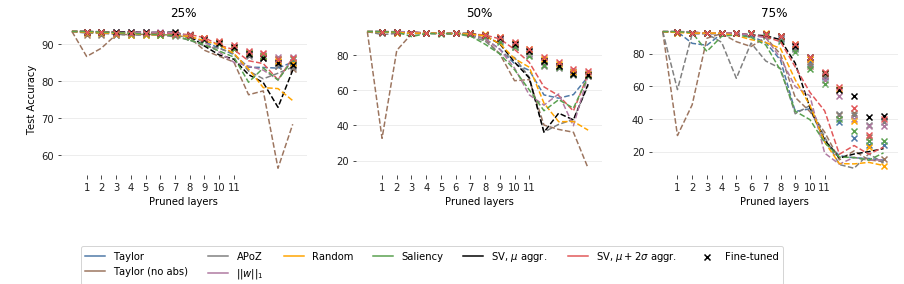

In [66]:
plot_data = pickle.load(open("data/lowdata_performance_results_sgd0.005_det.p", "rb" ))


fig, axes = plt.subplots(1, 3, figsize=(15,4))
for idx, sparsity in enumerate([0.25, 0.5, 0.75]):
    
    print (sparsity)
    ax = axes[idx]
    pre_finetune = plot_data["pre"][sparsity]
    post_finetune = plot_data["post"][sparsity]
    methods = pre_finetune.keys()
    for method_name in pre_finetune.keys():
        
        label, color = map_method_vis(method_name)
        acc_pre_mean = 100 * np.array(pre_finetune[method_name]).mean(0)[:, 1]
        acc_pre_std = 100 * np.array(pre_finetune[method_name]).std(0)[:, 1]
        acc_post_mean = 100 * np.array(post_finetune[method_name]).mean(0)[:, 1]
        acc_post_std = 100 * np.array(post_finetune[method_name]).std(0)[:, 1]
        ticks = range(len(acc_pre_mean))
        max_layer = 15
        
        print (method_name)
        print (f"Pre tuning:\t{acc_pre_mean[max_layer]:.2f} +- {acc_pre_std[max_layer]:.2f}")
        print (f"Pst tuning:\t{acc_post_mean[max_layer-1]:.2f} +- {acc_post_std[max_layer-1]:.2f}")

        ax.scatter(ticks[1:max_layer+1], acc_post_mean[:max_layer], marker='x', color=color, zorder=100 if "SV" in label else 1)
        ax.plot(ticks[:max_layer+1], acc_pre_mean[:max_layer+1], color=color, linestyle="dashed")
        ax.plot([], [], label=label, color=color, linestyle="solid")
        format_plt(ax, f"{sparsity * 100:.0f}%", "Pruned layers", "Test Accuracy" if idx == 0 else "")
        plt.xticks(np.arange(1, 12, step=1))

        
plt.scatter([], [], marker='x', color="black", label="Fine-tuned")
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "SV" in t[1] else -1))
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "Fine" in t[1] else -1))

fig.subplots_adjust(bottom=.35)
fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.40, 0.15), ncol=7)
plt.savefig(f"cifar10_pruning_lowdata_sgd0.005.pdf", bbox_inches='tight')